In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama_contrastive_classification_model_lora"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = Llama7BWithCCSHAP()


    df = pd.read_csv("cc-shap_data.csv")

   
    df["email_text"] = (
        df["subject"].fillna('') + "\nFrom: " + 
        df["sender"].fillna('') + "\n\n" + 
        df["body"].fillna('')
    )

  
    phishing_emails = df[df["label"] == 1].head(20)
    ham_emails = df[df["label"] == 0].head(20)

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    
    avg_phishing = np.mean(phishing_scores)
    avg_ham = np.mean(ham_scores)
    print(f"\nAverage CC‑SHAP Score for PHISHING emails: {avg_phishing:.3f}")
    print(f"Average CC‑SHAP Score for HAM emails: {avg_ham:.3f}")

    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

  
    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [avg_phishing, avg_ham],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter weights from llama_contrastive_classification_model_lora led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0
Processed PHISHING email 21: CC‑SHAP = 0.965 | Prediction: LEGITIMATE
Processed PHISHING email 22: CC‑SHAP = 0.972 | Prediction: LEGITIMATE
Processed PHISHING email 23: CC‑SHAP = 0.962 | Prediction: LEGITIMATE
Processed PHISHING email 24: CC‑SHAP = 0.957 | Prediction: LEGITIMATE


/home/users/skuikel/anaconda3/lib/python3.12/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


Processed PHISHING email 25: CC‑SHAP = nan | Prediction: PHISHING
Processed PHISHING email 26: CC‑SHAP = 0.964 | Prediction: LEGITIMATE
Processed PHISHING email 27: CC‑SHAP = nan | Prediction: PHISHING
Processed PHISHING email 28: CC‑SHAP = nan | Prediction: PHISHING
Processed PHISHING email 29: CC‑SHAP = 0.973 | Prediction: LEGITIMATE
Processed PHISHING email 30: CC‑SHAP = 0.972 | Prediction: LEGITIMATE
Processed PHISHING email 31: CC‑SHAP = 0.966 | Prediction: LEGITIMATE
Processed PHISHING email 32: CC‑SHAP = 0.969 | Prediction: LEGITIMATE
Processed PHISHING email 33: CC‑SHAP = 0.971 | Prediction: LEGITIMATE
Processed PHISHING email 34: CC‑SHAP = 0.964 | Prediction: LEGITIMATE
Processed PHISHING email 35: CC‑SHAP = 0.977 | Prediction: LEGITIMATE
Processed PHISHING email 36: CC‑SHAP = nan | Prediction: PHISHING
Processed PHISHING email 37: CC‑SHAP = 0.972 | Prediction: LEGITIMATE
Processed PHISHING email 38: CC‑SHAP = 0.971 | Prediction: LEGITIMATE
Processed PHISHING email 39: CC‑SHAP

KeyboardInterrupt: 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading adapter weights from llama8BBBBBB_contrastive_classification_model_lora led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = 0.956 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.953 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.946 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.921 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.957 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.923 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.954 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.968 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.914 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.937 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.912 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.563 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.954 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.744 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.920 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.871 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.865 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.962 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.952 | Prediction: PHISHING
Processed PHISHING email 40: CC‑SHAP = 0.951 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 1: CC‑SHAP = 0.843 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 2: CC‑SHAP = 0.836 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 3: CC‑SHAP = 0.944 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 4: CC‑SHAP = 0.954 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 5: CC‑SHAP = 0.902 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 6: CC‑SHAP = 0.927 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 7: CC‑SHAP = 0.882 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 8: CC‑SHAP = 0.954 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 9: CC‑SHAP = 0.963 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 10: CC‑SHAP = 0.912 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 11: CC‑SHAP = 0.945 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 12: CC‑SHAP = 0.953 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 13: CC‑SHAP = 0.943 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 14: CC‑SHAP = 0.961 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 15: CC‑SHAP = 0.940 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 16: CC‑SHAP = 0.957 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 17: CC‑SHAP = 0.941 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 18: CC‑SHAP = 0.872 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 19: CC‑SHAP = 0.927 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 20: CC‑SHAP = 0.838 | Prediction: LEGITIMATE

Average CC‑SHAP Score for PHISHING emails: 0.906
Average CC‑SHAP Score for HAM emails: 0.920


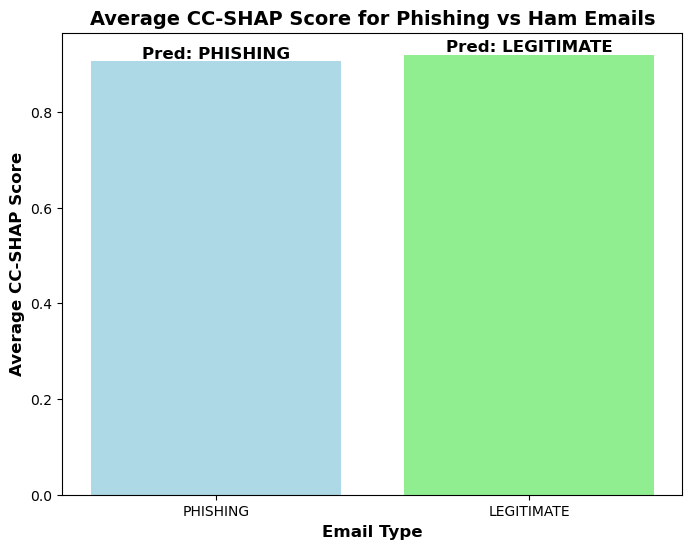

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter


nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama8BBBBBB_contrastive_classification_model_lora"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = Llama7BWithCCSHAP()


    df = pd.read_csv("cc-shap_data.csv")

   
    df["email_text"] = (
        df["subject"].fillna('') + "\nFrom: " + 
        df["sender"].fillna('') + "\n\n" + 
        df["body"].fillna('')
    )

  
    phishing_emails = df[df["label"] == 1].head(20)
    ham_emails = df[df["label"] == 0].head(20)

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    
    avg_phishing = np.mean(phishing_scores)
    avg_ham = np.mean(ham_scores)
    print(f"\nAverage CC‑SHAP Score for PHISHING emails: {avg_phishing:.3f}")
    print(f"Average CC‑SHAP Score for HAM emails: {avg_ham:.3f}")

    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

  
    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [avg_phishing, avg_ham],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading adapter weights from wiz_contrastive_classification_model_lora led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = 0.053 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.271 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.074 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.324 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.057 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.043 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 1: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 2: CC‑SHAP = 0.060 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 3: CC‑SHAP = 0.225 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 4: CC‑SHAP = 0.045 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 5: CC‑SHAP = 0.034 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 6: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 7: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 8: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 9: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 10: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 11: CC‑SHAP = 0.347 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 12: CC‑SHAP = 0.005 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 13: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 14: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 15: CC‑SHAP = 0.004 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 16: CC‑SHAP = 0.007 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 17: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 18: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 19: CC‑SHAP = 0.135 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 20: CC‑SHAP = 0.451 | Prediction: LEGITIMATE

Average CC‑SHAP Score for PHISHING emails: 0.041
Average CC‑SHAP Score for HAM emails: 0.066


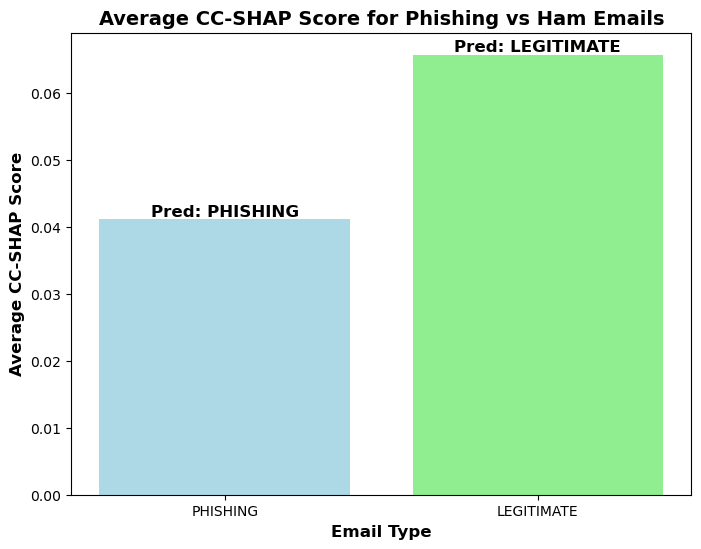

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "wiz_contrastive_classification_model_lora"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Tokenize text and move tensors to the model's device."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE and returns its probability."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

       
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the given prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """
        Computes the CC‑SHAP score (cosine similarity between SHAP values of prediction and explanation),
        the predicted class, and the generated explanation.
        """
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = (
            f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        )
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

        # Ensure both SHAP vectors are the same length
        min_len = min(len(pred_shap), len(exp_shap))
        pred_shap = pred_shap[:min_len]
        exp_shap = exp_shap[:min_len]

        # Normalize the vectors using L1 norm (with epsilon for stability)
        pred_norm = pred_shap / (np.linalg.norm(pred_shap, ord=1) + 1e-10)
        exp_norm = exp_shap / (np.linalg.norm(exp_shap, ord=1) + 1e-10)

       
        if np.linalg.norm(pred_norm, ord=2) < 1e-6 or np.linalg.norm(exp_norm, ord=2) < 1e-6:
            similarity = 0.0 
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = Llama7BWithCCSHAP()

    # Load data
    df = pd.read_csv("cc-shap_data.csv")

    # Create a full email text from subject, sender, and body columns
    df["email_text"] = (
        df["subject"].fillna('') + "\nFrom: " + 
        df["sender"].fillna('') + "\n\n" + 
        df["body"].fillna('')
    )

    phishing_emails = df[df["label"] == 1].head(20)
    ham_emails = df[df["label"] == 0].head(20)

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    avg_phishing = np.mean(phishing_scores)
    avg_ham = np.mean(ham_scores)
    print(f"\nAverage CC‑SHAP Score for PHISHING emails: {avg_phishing:.3f}")
    print(f"Average CC‑SHAP Score for HAM emails: {avg_ham:.3f}")

    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [avg_phishing, avg_ham],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading adapter weights from llama_8b_dpo123_classification_model led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention m

Processed PHISHING email 21: CC‑SHAP = 0.956 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.947 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.961 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.968 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.938 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.921 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.887 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.855 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.691 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.912 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.930 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.941 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.953 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.885 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.923 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.647 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.911 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.672 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.948 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.839 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 1: CC‑SHAP = 0.873 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 2: CC‑SHAP = 0.856 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 3: CC‑SHAP = 0.965 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 4: CC‑SHAP = 0.933 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 5: CC‑SHAP = 0.835 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 6: CC‑SHAP = 0.920 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 7: CC‑SHAP = 0.527 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 8: CC‑SHAP = 0.932 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 9: CC‑SHAP = 0.946 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 10: CC‑SHAP = 0.772 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 11: CC‑SHAP = 0.925 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 12: CC‑SHAP = 0.929 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 13: CC‑SHAP = 0.947 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 14: CC‑SHAP = 0.951 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 15: CC‑SHAP = 0.939 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 16: CC‑SHAP = 0.954 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 17: CC‑SHAP = 0.952 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 18: CC‑SHAP = 0.960 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 19: CC‑SHAP = 0.954 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 20: CC‑SHAP = 0.783 | Prediction: LEGITIMATE

Average CC‑SHAP Score for PHISHING emails: 0.884
Average CC‑SHAP Score for HAM emails: 0.893


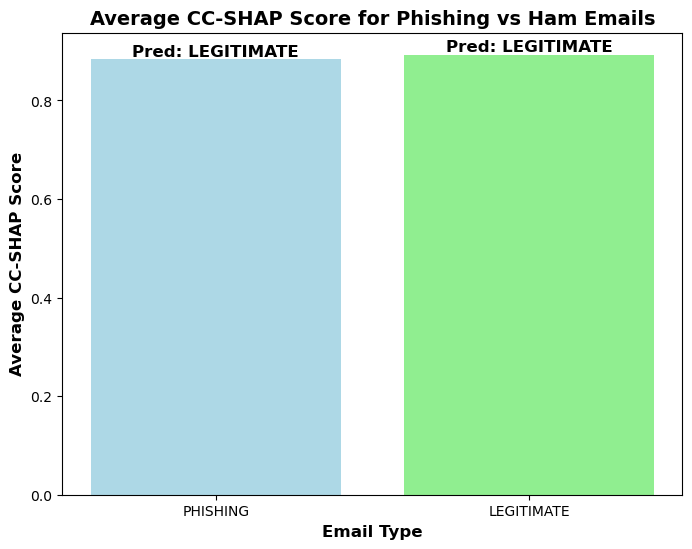

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama_8b_dpo123_classification_model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Tokenize text and move tensors to the model's device."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE and returns its probability."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Generate text and use a simple rule based on the presence of "PHISHING"
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the given prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling (limit samples to 100)
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        # Normalize using L1 norm with a small epsilon for numerical stability
        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """
        Computes the CC‑SHAP score (cosine similarity between SHAP values of prediction and explanation),
        the predicted class, and the generated explanation.
        """
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = (
            f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        )
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

        # Ensure both SHAP vectors are the same length
        min_len = min(len(pred_shap), len(exp_shap))
        pred_shap = pred_shap[:min_len]
        exp_shap = exp_shap[:min_len]

        # Normalize the vectors using L1 norm (with epsilon for stability)
        pred_norm = pred_shap / (np.linalg.norm(pred_shap, ord=1) + 1e-10)
        exp_norm = exp_shap / (np.linalg.norm(exp_shap, ord=1) + 1e-10)

        # Check if either normalized vector is nearly zero using the L2 norm.
        if np.linalg.norm(pred_norm, ord=2) < 1e-6 or np.linalg.norm(exp_norm, ord=2) < 1e-6:
            similarity = 0.0  # Default similarity when one vector is nearly zero.
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = Llama7BWithCCSHAP()

    # Load data
    df = pd.read_csv("cc-shap_data.csv")

    # Create a full email text from subject, sender, and body columns
    df["email_text"] = (
        df["subject"].fillna('') + "\nFrom: " + 
        df["sender"].fillna('') + "\n\n" + 
        df["body"].fillna('')
    )

    phishing_emails = df[df["label"] == 1].head(20)
    ham_emails = df[df["label"] == 0].head(20)

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    avg_phishing = np.mean(phishing_scores)
    avg_ham = np.mean(ham_scores)
    print(f"\nAverage CC‑SHAP Score for PHISHING emails: {avg_phishing:.3f}")
    print(f"Average CC‑SHAP Score for HAM emails: {avg_ham:.3f}")

    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [avg_phishing, avg_ham],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter weights from llama_7b_dpo123_classification_model led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0
Processed PHISHING email 21: CC‑SHAP = 0.964 | Prediction: LEGITIMATE
Processed PHISHING email 22: CC‑SHAP = 0.970 | Prediction: LEGITIMATE
Processed PHISHING email 23: CC‑SHAP = 0.972 | Prediction: LEGITIMATE
Processed PHISHING email 24: CC‑SHAP = 1.000 | Prediction: PHISHING
Processed PHISHING email 25: CC‑SHAP = 0.000 | Prediction: PHISHING
Processed PHISHING email 26: CC‑SHAP = 0.970 | Prediction: LEGITIMATE
Processed PHISHING email 27: CC‑SHAP = 0.970 | Prediction: LEGITIMATE
Processed PHISHING email 28: CC‑SHAP = 0.971 | Prediction: LEGITIMATE
Processed PHISHING email 29: CC‑SHAP = 0.000 | Prediction: PHISHING
Processed PHISHING email 30: CC‑SHAP = 0.968 | Prediction: LEGITIMATE
Processed PHISHING email 31: CC‑SHAP = 0.964 | Prediction: LEGITIMATE
Processed PHISHING email 32: CC‑SHAP = 1.000 | Prediction: PHISHING
Processed PHISHING email 33: CC‑SHAP = 0.972 | Prediction: LEGITIMATE
Processed PHISHING email 34: CC‑SHAP = 0.962 | Prediction: LEGITIMATE
Proce

posx and posy should be finite values
posx and posy should be finite values


Processed HAM email 20: CC‑SHAP = 0.964 | Prediction: LEGITIMATE

Average CC‑SHAP Score for PHISHING emails: 0.876
Average CC‑SHAP Score for HAM emails: nan


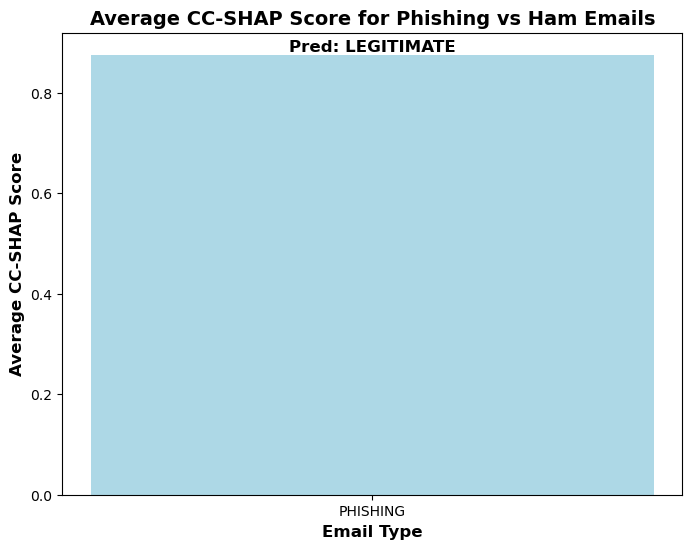

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

def safe_cosine_similarity(u: np.ndarray, v: np.ndarray, eps: float = 1e-6) -> float:
    """
    Computes the cosine similarity between two vectors u and v.
    If both vectors have near-zero L2 norm, return 1.0 (interpreting them as perfectly aligned).
    """
    norm_u = np.linalg.norm(u, ord=2)
    norm_v = np.linalg.norm(v, ord=2)
    if norm_u < eps and norm_v < eps:
        return 1.0
    return np.dot(u, v) / ((norm_u + eps) * (norm_v + eps))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama_7b_dpo123_classification_model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Set pad token as EOS token
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0"
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Tokenize the text and ensure the tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        device = next(self.model.parameters()).device
        return inputs["input_ids"].to(device), inputs["attention_mask"].to(device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Generates a prediction (PHISHING or LEGITIMATE) and returns its probability."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)
        # Generate a response and decide based on the presence of "PHISHING"
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
        class_idx = 0 if prediction == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """
        Computes SHAP values using structured coalition sampling.
        Returns a normalized SHAP vector.
        """
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)
        # Limit the number of samples to avoid excessive computation
        n_samples = min(2 ** n_tokens + 12, 100)
        
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()
        
        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)
            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  
            
            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))
            
            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()
            
            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples
        
        # Normalize the SHAP values with the L1 norm (adding a small epsilon for stability)
        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """
        Computes the CC‑SHAP score by comparing the SHAP vectors of the prediction prompt and the explanation prompt.
        Uses a safe cosine similarity function to avoid zero division.
        Returns the similarity, the predicted class, and the generated explanation.
        """
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)
        explanation = self.get_explanation(text, prediction)
        
        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = (
            f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        )
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)
        
        # Ensure both SHAP vectors have the same length
        min_len = min(len(pred_shap), len(exp_shap))
        pred_shap = pred_shap[:min_len]
        exp_shap = exp_shap[:min_len]
        
        similarity = safe_cosine_similarity(pred_shap, exp_shap)
        return similarity, prediction, explanation

if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = Llama7BWithCCSHAP()
    
    # Load the email data
    df = pd.read_csv("cc-shap_data.csv")
    
    # Construct full email texts from subject, sender, and body columns
    df["email_text"] = (
        df["subject"].fillna('') + "\nFrom: " +
        df["sender"].fillna('') + "\n\n" +
        df["body"].fillna('')
    )
    
    phishing_emails = df[df["label"] == 1].head(20)
    ham_emails = df[df["label"] == 0].head(20)
    
    phishing_scores = []
    phishing_predictions = []
    
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")
    
    ham_scores = []
    ham_predictions = []
    
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")
    
    avg_phishing = np.mean(phishing_scores)
    avg_ham = np.mean(ham_scores)
    
    print(f"\nAverage CC‑SHAP Score for PHISHING emails: {avg_phishing:.3f}")
    print(f"Average CC‑SHAP Score for HAM emails: {avg_ham:.3f}")
    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [avg_phishing, avg_ham],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')
    
    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading adapter weights from wizard8b_binary_classification_model led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = 0.164 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.131 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.141 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 1: CC‑SHAP = 0.074 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 2: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 3: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 4: CC‑SHAP = 0.111 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 5: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 6: CC‑SHAP = 0.161 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 7: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 8: CC‑SHAP = 0.087 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 9: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 10: CC‑SHAP = 0.224 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 11: CC‑SHAP = 0.166 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 12: CC‑SHAP = 0.198 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 13: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 14: CC‑SHAP = 0.150 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 15: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 16: CC‑SHAP = 0.173 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 17: CC‑SHAP = 0.113 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 18: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 19: CC‑SHAP = 0.126 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 20: CC‑SHAP = 0.072 | Prediction: LEGITIMATE

Average CC‑SHAP Score for PHISHING emails: 0.022
Average CC‑SHAP Score for HAM emails: 0.083


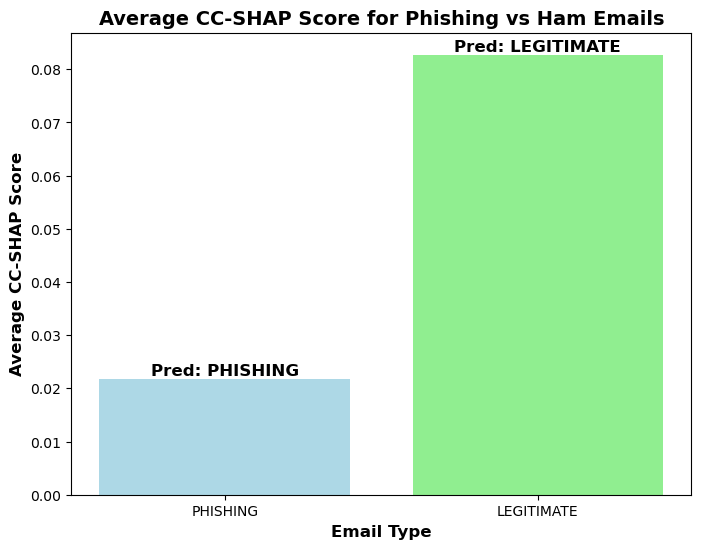

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "wizard8b_binary_classification_model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Tokenize text and move tensors to the model's device."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE and returns its probability."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Generate text and use a simple rule based on the presence of "PHISHING"
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the given prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling (limit samples to 100)
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        # Normalize using L1 norm with a small epsilon for numerical stability
        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """
        Computes the CC‑SHAP score (cosine similarity between SHAP values of prediction and explanation),
        the predicted class, and the generated explanation.
        """
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = (
            f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        )
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

        # Ensure both SHAP vectors are the same length
        min_len = min(len(pred_shap), len(exp_shap))
        pred_shap = pred_shap[:min_len]
        exp_shap = exp_shap[:min_len]

        # Normalize the vectors using L1 norm (with epsilon for stability)
        pred_norm = pred_shap / (np.linalg.norm(pred_shap, ord=1) + 1e-10)
        exp_norm = exp_shap / (np.linalg.norm(exp_shap, ord=1) + 1e-10)

        # Check if either normalized vector is nearly zero using the L2 norm.
        if np.linalg.norm(pred_norm, ord=2) < 1e-6 or np.linalg.norm(exp_norm, ord=2) < 1e-6:
            similarity = 0.0  # Default similarity when one vector is nearly zero.
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = Llama7BWithCCSHAP()

    # Load data
    df = pd.read_csv("cc-shap_data.csv")

    # Create a full email text from subject, sender, and body columns
    df["email_text"] = (
        df["subject"].fillna('') + "\nFrom: " + 
        df["sender"].fillna('') + "\n\n" + 
        df["body"].fillna('')
    )

    phishing_emails = df[df["label"] == 1].head(20)
    ham_emails = df[df["label"] == 0].head(20)

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, _ = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    avg_phishing = np.mean(phishing_scores)
    avg_ham = np.mean(ham_scores)
    print(f"\nAverage CC‑SHAP Score for PHISHING emails: {avg_phishing:.3f}")
    print(f"Average CC‑SHAP Score for HAM emails: {avg_ham:.3f}")

    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [avg_phishing, avg_ham],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading adapter weights from wiz_contrastive_classification_model_lora led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 1: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 2: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 3: CC‑SHAP = 0.116 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 4: CC‑SHAP = 0.087 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 5: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 6: CC‑SHAP = 0.136 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 7: CC‑SHAP = 0.020 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 8: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 9: CC‑SHAP = 0.050 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 10: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 11: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 12: CC‑SHAP = 0.515 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 13: CC‑SHAP = 0.121 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 14: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 15: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 16: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 17: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 18: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 19: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 20: CC‑SHAP = 0.026 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.073 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.161 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.051 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.104 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.223 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 41: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 42: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 43: CC‑SHAP = 0.221 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 44: CC‑SHAP = 0.194 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 45: CC‑SHAP = 0.144 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 46: CC‑SHAP = 0.161 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 47: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 48: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 49: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 50: CC‑SHAP = 0.057 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 51: CC‑SHAP = 0.012 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 52: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 53: CC‑SHAP = 0.040 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 54: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 55: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 56: CC‑SHAP = 0.016 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 57: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 58: CC‑SHAP = 0.004 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 59: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 60: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 61: CC‑SHAP = 0.204 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 62: CC‑SHAP = 0.005 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 63: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 64: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 65: CC‑SHAP = 0.201 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 66: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 67: CC‑SHAP = 0.059 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 68: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 69: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 70: CC‑SHAP = 0.363 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 71: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 72: CC‑SHAP = 0.088 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 73: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 74: CC‑SHAP = 0.156 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 75: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 76: CC‑SHAP = 0.011 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 77: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 78: CC‑SHAP = 0.247 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 79: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 80: CC‑SHAP = 0.123 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 81: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 82: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 83: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 84: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 85: CC‑SHAP = 0.030 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 86: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 87: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 88: CC‑SHAP = 0.018 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 89: CC‑SHAP = 0.130 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 90: CC‑SHAP = 0.034 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 91: CC‑SHAP = 0.186 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 92: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 93: CC‑SHAP = 0.043 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 94: CC‑SHAP = 0.097 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 95: CC‑SHAP = 0.041 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 96: CC‑SHAP = 0.200 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 97: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 98: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 99: CC‑SHAP = 0.291 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 100: CC‑SHAP = 0.393 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 101: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 102: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 103: CC‑SHAP = 0.002 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 104: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 105: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 106: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 107: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 108: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 109: CC‑SHAP = 0.140 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 110: CC‑SHAP = 0.197 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 111: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 112: CC‑SHAP = 0.050 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 113: CC‑SHAP = 0.082 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 114: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 115: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 116: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 117: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 118: CC‑SHAP = 0.026 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 119: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 120: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 121: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 122: CC‑SHAP = 0.124 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 123: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 124: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 125: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 126: CC‑SHAP = 0.033 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 127: CC‑SHAP = 0.101 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 128: CC‑SHAP = 0.188 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 129: CC‑SHAP = 0.184 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 130: CC‑SHAP = 0.141 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 131: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 132: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 133: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 134: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 135: CC‑SHAP = 0.008 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 136: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 137: CC‑SHAP = 0.222 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 138: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 139: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 140: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 141: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 142: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 143: CC‑SHAP = 0.100 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 144: CC‑SHAP = 0.166 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 145: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 146: CC‑SHAP = 0.148 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 147: CC‑SHAP = 0.066 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 148: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 149: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 150: CC‑SHAP = 0.009 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 151: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 152: CC‑SHAP = 0.112 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 153: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 154: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 155: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 156: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 157: CC‑SHAP = 0.325 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 158: CC‑SHAP = 0.241 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 159: CC‑SHAP = 0.408 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 160: CC‑SHAP = 0.034 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 161: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 162: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 163: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 164: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 165: CC‑SHAP = 0.123 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 166: CC‑SHAP = 0.015 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 167: CC‑SHAP = 0.136 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 168: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 169: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 170: CC‑SHAP = 0.132 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 171: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 172: CC‑SHAP = 0.291 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 173: CC‑SHAP = 0.002 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 174: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 175: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 176: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 177: CC‑SHAP = 0.110 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 178: CC‑SHAP = 0.215 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 179: CC‑SHAP = 0.082 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 180: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 181: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 182: CC‑SHAP = 0.044 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 183: CC‑SHAP = 0.092 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 184: CC‑SHAP = 0.102 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 185: CC‑SHAP = 0.021 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 186: CC‑SHAP = 0.096 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 187: CC‑SHAP = 0.180 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 188: CC‑SHAP = 0.006 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 189: CC‑SHAP = 0.464 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 190: CC‑SHAP = 0.094 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 191: CC‑SHAP = 0.003 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 192: CC‑SHAP = 0.046 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 193: CC‑SHAP = 0.209 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 194: CC‑SHAP = 0.046 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 195: CC‑SHAP = 0.164 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 196: CC‑SHAP = 0.006 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 197: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 198: CC‑SHAP = 0.140 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 199: CC‑SHAP = 0.004 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 200: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 201: CC‑SHAP = 0.031 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 202: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 203: CC‑SHAP = 0.363 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 204: CC‑SHAP = 0.081 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 205: CC‑SHAP = 0.139 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 206: CC‑SHAP = 0.104 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 207: CC‑SHAP = 0.091 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 208: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 209: CC‑SHAP = 0.278 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 210: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 211: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 212: CC‑SHAP = 0.139 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 213: CC‑SHAP = 0.116 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 214: CC‑SHAP = 0.017 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 215: CC‑SHAP = 0.057 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 216: CC‑SHAP = 0.237 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 217: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 218: CC‑SHAP = 0.130 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 219: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 220: CC‑SHAP = 0.365 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 221: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 222: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 223: CC‑SHAP = 0.131 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 224: CC‑SHAP = 0.142 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 225: CC‑SHAP = 0.120 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 226: CC‑SHAP = 0.125 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 227: CC‑SHAP = 0.059 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 228: CC‑SHAP = 0.408 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 229: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 230: CC‑SHAP = 0.150 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 231: CC‑SHAP = 0.033 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 232: CC‑SHAP = 0.180 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 233: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 234: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 235: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 236: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 237: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 238: CC‑SHAP = 0.330 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 239: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 240: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 241: CC‑SHAP = 0.000 | Prediction: PHISHING

Phishing Accuracy: 69.89%
Ham Accuracy: 81.82%

Phishing CC‑SHAP Mean: 0.054 | Std: 0.092
Ham CC‑SHAP Mean: 0.094 | Std: 0.118


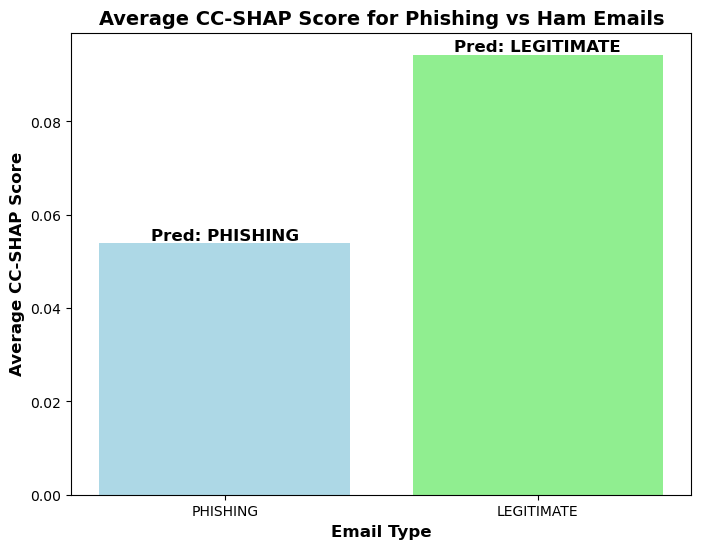

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "wiz_contrastive_classification_model_lora"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Tokenize text and move tensors to the model's device."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE and returns its probability."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the given prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

      
        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """
        Computes the CC‑SHAP score (cosine similarity between SHAP values of prediction and explanation),
        the predicted class, and the generated explanation.
        """
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = (
            f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        )
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_shap = pred_shap[:min_len]
        exp_shap = exp_shap[:min_len]

       
        pred_norm = pred_shap / (np.linalg.norm(pred_shap, ord=1) + 1e-10)
        exp_norm = exp_shap / (np.linalg.norm(exp_shap, ord=1) + 1e-10)

       
        if np.linalg.norm(pred_norm, ord=2) < 1e-6 or np.linalg.norm(exp_norm, ord=2) < 1e-6:
            similarity = 0.0 
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
   
    analyzer = Llama7BWithCCSHAP()

  
    df = pd.read_excel("Original_data.xlsx")

   
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

   
    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]



    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

   
    phishing_accuracy = np.mean([1 if pred == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred == "LEGITIMATE" else 0 for pred in ham_predictions])

   
    phishing_cc_shap_mean = np.mean(phishing_scores)
    phishing_cc_shap_std = np.std(phishing_scores)
    ham_cc_shap_mean = np.mean(ham_scores)
    ham_cc_shap_std = np.std(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")

    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading adapter weights from llama8BBBBBB_contrastive_classification_model_lora led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention m

Processed PHISHING email 1: CC‑SHAP = 0.825 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 2: CC‑SHAP = 0.935 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 3: CC‑SHAP = 0.741 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 4: CC‑SHAP = 0.316 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 5: CC‑SHAP = 0.832 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 6: CC‑SHAP = 0.939 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 7: CC‑SHAP = 0.854 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 8: CC‑SHAP = 0.820 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 9: CC‑SHAP = 0.907 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 10: CC‑SHAP = 0.765 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 11: CC‑SHAP = 0.728 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 12: CC‑SHAP = 0.741 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 13: CC‑SHAP = 0.863 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 14: CC‑SHAP = 0.634 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 15: CC‑SHAP = 0.678 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 16: CC‑SHAP = 0.856 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 17: CC‑SHAP = 0.758 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 18: CC‑SHAP = 0.853 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 19: CC‑SHAP = 0.683 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 20: CC‑SHAP = 0.960 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = 0.790 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.834 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.831 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.943 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.841 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.920 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.804 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.466 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.875 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.906 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.822 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.846 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.932 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.944 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.824 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.864 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.743 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.946 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.826 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.811 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 41: CC‑SHAP = 0.790 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 42: CC‑SHAP = 0.717 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 43: CC‑SHAP = 0.903 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 44: CC‑SHAP = 0.926 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 45: CC‑SHAP = 0.878 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 46: CC‑SHAP = 0.938 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 47: CC‑SHAP = 0.528 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 48: CC‑SHAP = 0.753 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 49: CC‑SHAP = 0.625 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 50: CC‑SHAP = 0.925 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 51: CC‑SHAP = 0.649 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 52: CC‑SHAP = 0.829 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 53: CC‑SHAP = 0.912 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 54: CC‑SHAP = 0.854 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 55: CC‑SHAP = 0.865 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 56: CC‑SHAP = 0.879 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 57: CC‑SHAP = 0.771 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 58: CC‑SHAP = 0.910 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 59: CC‑SHAP = 0.699 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 60: CC‑SHAP = 0.457 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 61: CC‑SHAP = 0.956 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 62: CC‑SHAP = 0.962 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 63: CC‑SHAP = 0.520 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 64: CC‑SHAP = 0.764 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 65: CC‑SHAP = 0.933 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 66: CC‑SHAP = 0.845 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 67: CC‑SHAP = 0.908 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 68: CC‑SHAP = 0.880 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 69: CC‑SHAP = 0.367 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 70: CC‑SHAP = 0.586 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 71: CC‑SHAP = 0.958 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 72: CC‑SHAP = 0.912 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 73: CC‑SHAP = 0.858 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 74: CC‑SHAP = 0.785 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 75: CC‑SHAP = 0.913 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 76: CC‑SHAP = 0.769 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 77: CC‑SHAP = 0.496 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 78: CC‑SHAP = 0.781 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 79: CC‑SHAP = 0.845 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 80: CC‑SHAP = 0.943 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 81: CC‑SHAP = 0.943 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 82: CC‑SHAP = 0.827 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 83: CC‑SHAP = 0.780 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 84: CC‑SHAP = 0.478 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 85: CC‑SHAP = 0.567 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 86: CC‑SHAP = 0.860 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 87: CC‑SHAP = 0.888 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 88: CC‑SHAP = 0.385 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 89: CC‑SHAP = 0.811 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 90: CC‑SHAP = 0.938 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 91: CC‑SHAP = 0.906 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 92: CC‑SHAP = 0.822 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 93: CC‑SHAP = 0.841 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 94: CC‑SHAP = 0.903 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 95: CC‑SHAP = 0.893 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 96: CC‑SHAP = 0.748 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 97: CC‑SHAP = 0.659 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 98: CC‑SHAP = 0.188 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 99: CC‑SHAP = 0.379 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 100: CC‑SHAP = 0.767 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 101: CC‑SHAP = 0.919 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 102: CC‑SHAP = 0.912 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 103: CC‑SHAP = 0.924 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 104: CC‑SHAP = 0.889 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 105: CC‑SHAP = 0.717 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 106: CC‑SHAP = 0.895 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 107: CC‑SHAP = 0.906 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 108: CC‑SHAP = 0.923 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 109: CC‑SHAP = 0.836 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 110: CC‑SHAP = 0.917 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 111: CC‑SHAP = 0.935 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 112: CC‑SHAP = 0.912 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 113: CC‑SHAP = 0.858 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 114: CC‑SHAP = 0.881 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 115: CC‑SHAP = 0.737 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 116: CC‑SHAP = 0.835 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 117: CC‑SHAP = 0.785 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 118: CC‑SHAP = 0.721 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 119: CC‑SHAP = 0.940 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 120: CC‑SHAP = 0.937 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 121: CC‑SHAP = 0.921 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 122: CC‑SHAP = 0.785 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 123: CC‑SHAP = 0.917 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 124: CC‑SHAP = 0.939 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 125: CC‑SHAP = 0.868 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 126: CC‑SHAP = 0.839 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 127: CC‑SHAP = 0.893 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processed PHISHING email 128: CC‑SHAP = 0.952 | Prediction: PHISHING


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 129: CC‑SHAP = 0.952 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 130: CC‑SHAP = 0.811 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 131: CC‑SHAP = 0.903 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 132: CC‑SHAP = 0.852 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Processed PHISHING email 133: CC‑SHAP = 0.809 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 134: CC‑SHAP = 0.854 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 135: CC‑SHAP = 0.894 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 136: CC‑SHAP = 0.943 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 137: CC‑SHAP = 0.783 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 138: CC‑SHAP = 0.854 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 139: CC‑SHAP = 0.828 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 140: CC‑SHAP = 0.820 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 141: CC‑SHAP = 0.848 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 142: CC‑SHAP = 0.855 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 143: CC‑SHAP = 0.664 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 144: CC‑SHAP = 0.935 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 145: CC‑SHAP = 0.748 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 146: CC‑SHAP = 0.644 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 147: CC‑SHAP = 0.871 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 148: CC‑SHAP = 0.953 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 149: CC‑SHAP = 0.626 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 150: CC‑SHAP = 0.924 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 151: CC‑SHAP = 0.752 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 152: CC‑SHAP = 0.914 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 153: CC‑SHAP = 0.796 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 154: CC‑SHAP = 0.887 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 155: CC‑SHAP = 0.687 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 156: CC‑SHAP = 0.667 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 157: CC‑SHAP = 0.729 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 158: CC‑SHAP = 0.699 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 159: CC‑SHAP = 0.892 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 160: CC‑SHAP = 0.792 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 161: CC‑SHAP = 0.900 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 162: CC‑SHAP = 0.951 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 163: CC‑SHAP = 0.846 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 164: CC‑SHAP = 0.374 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 165: CC‑SHAP = 0.706 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 166: CC‑SHAP = 0.497 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 167: CC‑SHAP = 0.732 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 168: CC‑SHAP = 0.949 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 169: CC‑SHAP = 0.918 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 170: CC‑SHAP = 0.240 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 171: CC‑SHAP = 0.810 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 172: CC‑SHAP = 0.933 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 173: CC‑SHAP = 0.551 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 174: CC‑SHAP = 0.848 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 175: CC‑SHAP = 0.895 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 176: CC‑SHAP = 0.822 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 177: CC‑SHAP = 0.944 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 178: CC‑SHAP = 0.818 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processed PHISHING email 179: CC‑SHAP = 0.954 | Prediction: PHISHING


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 180: CC‑SHAP = 0.947 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 181: CC‑SHAP = 0.898 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 182: CC‑SHAP = 0.794 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 183: CC‑SHAP = 0.936 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 184: CC‑SHAP = 0.392 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 185: CC‑SHAP = 0.871 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 186: CC‑SHAP = 0.939 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 187: CC‑SHAP = 0.745 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 188: CC‑SHAP = 0.898 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 189: CC‑SHAP = 0.396 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 190: CC‑SHAP = 0.564 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 191: CC‑SHAP = 0.791 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 192: CC‑SHAP = 0.687 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 193: CC‑SHAP = 0.897 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 194: CC‑SHAP = 0.910 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 195: CC‑SHAP = 0.893 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 196: CC‑SHAP = 0.900 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 197: CC‑SHAP = 0.653 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 198: CC‑SHAP = 0.662 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 199: CC‑SHAP = 0.798 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 200: CC‑SHAP = 0.748 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 201: CC‑SHAP = 0.787 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 202: CC‑SHAP = 0.670 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 203: CC‑SHAP = 0.913 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 204: CC‑SHAP = 0.923 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 205: CC‑SHAP = 0.680 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 206: CC‑SHAP = 0.717 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 207: CC‑SHAP = 0.802 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 208: CC‑SHAP = 0.918 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 209: CC‑SHAP = 0.839 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 210: CC‑SHAP = 0.881 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 211: CC‑SHAP = 0.663 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 212: CC‑SHAP = 0.881 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 213: CC‑SHAP = 0.864 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 214: CC‑SHAP = 0.779 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 215: CC‑SHAP = 0.787 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 216: CC‑SHAP = 0.940 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 217: CC‑SHAP = 0.605 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 218: CC‑SHAP = 0.581 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 219: CC‑SHAP = 0.814 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 220: CC‑SHAP = 0.770 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 221: CC‑SHAP = 0.777 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 222: CC‑SHAP = 0.958 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 223: CC‑SHAP = 0.753 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 224: CC‑SHAP = 0.935 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 225: CC‑SHAP = 0.853 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 226: CC‑SHAP = 0.834 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 227: CC‑SHAP = 0.796 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 228: CC‑SHAP = 0.803 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 229: CC‑SHAP = 0.907 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 230: CC‑SHAP = 0.688 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 231: CC‑SHAP = 0.945 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 232: CC‑SHAP = 0.879 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 233: CC‑SHAP = 0.726 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 234: CC‑SHAP = 0.725 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 235: CC‑SHAP = 0.847 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 236: CC‑SHAP = 0.870 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 237: CC‑SHAP = 0.808 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 238: CC‑SHAP = 0.888 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 239: CC‑SHAP = 0.835 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 240: CC‑SHAP = 0.814 | Prediction: PHISHING
Processed HAM email 241: CC‑SHAP = 0.843 | Prediction: PHISHING

Phishing Accuracy: 25.27%
Ham Accuracy: 87.27%

Phishing CC‑SHAP Mean: 0.806 | Std: 0.150
Ham CC‑SHAP Mean: 0.797 | Std: 0.111


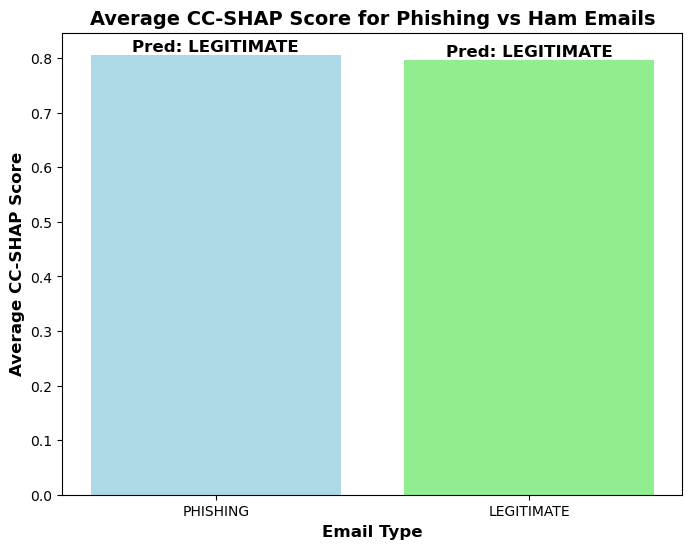

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama8BBBBBB_contrastive_classification_model_lora"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Tokenize text and move tensors to the model's device."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE and returns its probability."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the given prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

      
        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """
        Computes the CC‑SHAP score (cosine similarity between SHAP values of prediction and explanation),
        the predicted class, and the generated explanation.
        """
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = (
            f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        )
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_shap = pred_shap[:min_len]
        exp_shap = exp_shap[:min_len]

       
        pred_norm = pred_shap / (np.linalg.norm(pred_shap, ord=1) + 1e-10)
        exp_norm = exp_shap / (np.linalg.norm(exp_shap, ord=1) + 1e-10)

       
        if np.linalg.norm(pred_norm, ord=2) < 1e-6 or np.linalg.norm(exp_norm, ord=2) < 1e-6:
            similarity = 0.0 
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
   
    analyzer = Llama7BWithCCSHAP()

  
    df = pd.read_excel("Original_data.xlsx")

   
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

   
    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]



    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

   
    phishing_accuracy = np.mean([1 if pred == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred == "LEGITIMATE" else 0 for pred in ham_predictions])

   
    phishing_cc_shap_mean = np.mean(phishing_scores)
    phishing_cc_shap_std = np.std(phishing_scores)
    ham_cc_shap_mean = np.mean(ham_scores)
    ham_cc_shap_std = np.std(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")

    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple, List, Dict, Any
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForSequenceClassification
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama_8b_dpo123_classification_model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
    analyzer = Llama7BWithCCSHAP()

    # Load data from Excel
    df = pd.read_excel("Original_data.xlsx")
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    # Calculate accuracies using nan-safe aggregations
    phishing_accuracy = np.mean([1 if pred.upper() == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred.upper() == "LEGITIMATE" else 0 for pred in ham_predictions])

    phishing_cc_shap_mean = np.nanmean(phishing_scores)
    phishing_cc_shap_std = np.nanstd(phishing_scores)
    ham_cc_shap_mean = np.nanmean(ham_scores)
    ham_cc_shap_std = np.nanstd(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")
    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x
() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 82.56 MiB is free. Process 811229 has 13.79 GiB memory in use. Including non-PyTorch memory, this process has 9.79 GiB memory in use. Of the allocated memory 9.51 GiB is allocated by PyTorch, and 85.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading adapter weights from wizard_7b_dpo_classification_model led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 1: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 2: CC‑SHAP = 0.226 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/users/skuikel/anaconda3/lib/python3.12/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 3: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 4: CC‑SHAP = 0.102 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 5: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 6: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 7: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 8: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 9: CC‑SHAP = 0.253 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 10: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 11: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 12: CC‑SHAP = 0.016 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 13: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 14: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 15: CC‑SHAP = 0.034 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 16: CC‑SHAP = 0.176 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 17: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 18: CC‑SHAP = 0.039 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 19: CC‑SHAP = 0.236 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 20: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.002 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.410 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.013 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.046 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.004 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 41: CC‑SHAP = 0.151 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 42: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 43: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 44: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 45: CC‑SHAP = 0.200 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 46: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 47: CC‑SHAP = 0.254 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 48: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 49: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 50: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 51: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 52: CC‑SHAP = 0.275 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 53: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 54: CC‑SHAP = 0.121 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 55: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 56: CC‑SHAP = 0.255 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 57: CC‑SHAP = 0.579 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 58: CC‑SHAP = 0.005 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 59: CC‑SHAP = 0.086 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 60: CC‑SHAP = 0.002 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 61: CC‑SHAP = 0.239 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 62: CC‑SHAP = 0.248 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 63: CC‑SHAP = 0.021 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 64: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 65: CC‑SHAP = 0.012 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 66: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 67: CC‑SHAP = 0.120 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 68: CC‑SHAP = 0.126 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 69: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 70: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 71: CC‑SHAP = 0.143 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 72: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 73: CC‑SHAP = 0.029 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 74: CC‑SHAP = 0.049 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 75: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 76: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 77: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 78: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 79: CC‑SHAP = 0.208 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 80: CC‑SHAP = 0.094 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 81: CC‑SHAP = 0.134 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 82: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 83: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 84: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 85: CC‑SHAP = 0.051 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 86: CC‑SHAP = 0.435 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 87: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 88: CC‑SHAP = 0.203 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 89: CC‑SHAP = 0.124 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 90: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 91: CC‑SHAP = 0.034 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 92: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 93: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 94: CC‑SHAP = 0.007 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 95: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 96: CC‑SHAP = 0.159 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 97: CC‑SHAP = 0.040 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 98: CC‑SHAP = 0.015 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 99: CC‑SHAP = 0.149 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 100: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 101: CC‑SHAP = 0.020 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 102: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 103: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 104: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 105: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 106: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 107: CC‑SHAP = 0.054 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 108: CC‑SHAP = 0.078 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 109: CC‑SHAP = 0.095 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 110: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 111: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 112: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 113: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 114: CC‑SHAP = 0.108 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 115: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 116: CC‑SHAP = 0.007 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 117: CC‑SHAP = 0.192 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 118: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 119: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 120: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 121: CC‑SHAP = 0.149 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 122: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 123: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 124: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 125: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 126: CC‑SHAP = 0.023 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 127: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 128: CC‑SHAP = 0.110 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 129: CC‑SHAP = 0.117 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 130: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 131: CC‑SHAP = 0.084 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 132: CC‑SHAP = 0.069 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 133: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 134: CC‑SHAP = 0.084 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 135: CC‑SHAP = 0.020 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 136: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 137: CC‑SHAP = 0.044 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 138: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 139: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 140: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 141: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 142: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 143: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 144: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 145: CC‑SHAP = 0.103 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 146: CC‑SHAP = 0.088 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 147: CC‑SHAP = 0.059 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 148: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 149: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 150: CC‑SHAP = 0.145 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 151: CC‑SHAP = 0.259 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 152: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 153: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 154: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 155: CC‑SHAP = 0.219 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 156: CC‑SHAP = 0.060 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 157: CC‑SHAP = 0.166 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 158: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 159: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 160: CC‑SHAP = 0.406 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 161: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 162: CC‑SHAP = 0.002 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 163: CC‑SHAP = 0.022 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 164: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 165: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 166: CC‑SHAP = 0.116 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 167: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 168: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 169: CC‑SHAP = 0.357 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 170: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 171: CC‑SHAP = 0.100 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 172: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 173: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 174: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 175: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 176: CC‑SHAP = 0.022 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 177: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 178: CC‑SHAP = 0.165 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 179: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 180: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 181: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 182: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 183: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 184: CC‑SHAP = 0.002 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 185: CC‑SHAP = 0.100 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 186: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 187: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 188: CC‑SHAP = 0.473 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 189: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 190: CC‑SHAP = 0.021 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 191: CC‑SHAP = 0.208 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 192: CC‑SHAP = 0.016 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 193: CC‑SHAP = 0.268 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 194: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 195: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 196: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 197: CC‑SHAP = 0.488 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 198: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 199: CC‑SHAP = 0.122 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 200: CC‑SHAP = 0.015 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 201: CC‑SHAP = 0.005 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 202: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 203: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 204: CC‑SHAP = 0.197 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 205: CC‑SHAP = 0.065 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 206: CC‑SHAP = 0.004 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 207: CC‑SHAP = 0.411 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 208: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 209: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 210: CC‑SHAP = 0.086 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 211: CC‑SHAP = 0.831 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 212: CC‑SHAP = 0.179 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 213: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 214: CC‑SHAP = 0.191 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 215: CC‑SHAP = 0.188 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 216: CC‑SHAP = nan | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 217: CC‑SHAP = 0.002 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 218: CC‑SHAP = 0.022 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 219: CC‑SHAP = 0.257 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 220: CC‑SHAP = 0.006 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 221: CC‑SHAP = 0.056 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 222: CC‑SHAP = 0.101 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 223: CC‑SHAP = 0.092 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 224: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 225: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 226: CC‑SHAP = 0.169 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 227: CC‑SHAP = 0.012 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 228: CC‑SHAP = 0.230 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 229: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 230: CC‑SHAP = 0.002 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 231: CC‑SHAP = 0.077 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 232: CC‑SHAP = 0.081 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 233: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 234: CC‑SHAP = 0.256 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 235: CC‑SHAP = nan | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 236: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 237: CC‑SHAP = 0.203 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 238: CC‑SHAP = 0.222 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 239: CC‑SHAP = 0.182 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 240: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 241: CC‑SHAP = 0.000 | Prediction: PHISHING

Phishing Accuracy: 73.12%
Ham Accuracy: 80.00%

Phishing CC‑SHAP Mean: 0.087 | Std: 0.111
Ham CC‑SHAP Mean: 0.134 | Std: 0.168


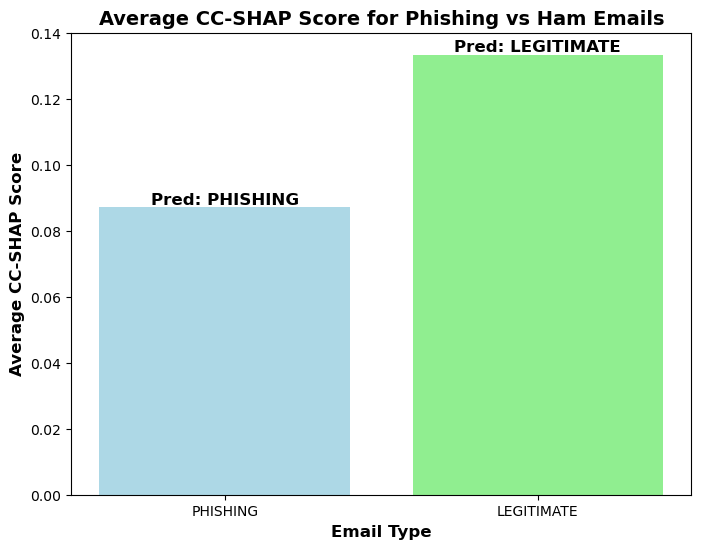

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple, List, Dict, Any
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForSequenceClassification
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "wizard_7b_dpo_classification_model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
    analyzer = Llama7BWithCCSHAP()

    # Load data from Excel
    df = pd.read_excel("Original_data.xlsx")
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    # Calculate accuracies using nan-safe aggregations
    phishing_accuracy = np.mean([1 if pred.upper() == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred.upper() == "LEGITIMATE" else 0 for pred in ham_predictions])

    phishing_cc_shap_mean = np.nanmean(phishing_scores)
    phishing_cc_shap_std = np.nanstd(phishing_scores)
    ham_cc_shap_mean = np.nanmean(ham_scores)
    ham_cc_shap_std = np.nanstd(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")
    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x
() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading adapter weights from llama_8b_dpo123_classification_model led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 1: CC‑SHAP = 0.894 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 2: CC‑SHAP = 0.775 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 3: CC‑SHAP = 0.756 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 4: CC‑SHAP = 0.931 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 5: CC‑SHAP = 0.912 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 6: CC‑SHAP = 0.916 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 7: CC‑SHAP = 0.690 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 8: CC‑SHAP = 0.678 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 9: CC‑SHAP = 0.892 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 10: CC‑SHAP = 0.870 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 11: CC‑SHAP = 0.933 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 12: CC‑SHAP = 0.862 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 13: CC‑SHAP = 0.954 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 14: CC‑SHAP = 0.674 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 15: CC‑SHAP = 0.427 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 16: CC‑SHAP = 0.899 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 17: CC‑SHAP = 0.688 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 18: CC‑SHAP = 0.613 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 19: CC‑SHAP = 0.895 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 20: CC‑SHAP = 0.824 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = 0.878 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.908 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.927 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.920 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.804 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.827 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.911 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.948 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.876 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.571 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.876 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.821 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.789 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.905 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.805 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.938 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.468 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.948 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.599 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.500 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 41: CC‑SHAP = 0.522 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 42: CC‑SHAP = 0.957 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 43: CC‑SHAP = 0.938 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 44: CC‑SHAP = 0.768 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 45: CC‑SHAP = 0.921 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 46: CC‑SHAP = 0.923 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 47: CC‑SHAP = 0.931 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 48: CC‑SHAP = 0.956 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 49: CC‑SHAP = 0.911 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 50: CC‑SHAP = 0.697 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 51: CC‑SHAP = 0.740 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 52: CC‑SHAP = 0.908 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 53: CC‑SHAP = 0.605 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 54: CC‑SHAP = 0.684 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 55: CC‑SHAP = 0.864 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 56: CC‑SHAP = 0.915 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 57: CC‑SHAP = 0.848 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 58: CC‑SHAP = 0.918 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 59: CC‑SHAP = 0.573 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 60: CC‑SHAP = 0.692 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 61: CC‑SHAP = 0.955 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 62: CC‑SHAP = 0.928 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 63: CC‑SHAP = 0.666 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 64: CC‑SHAP = 0.396 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 65: CC‑SHAP = 0.927 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 66: CC‑SHAP = 0.826 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 67: CC‑SHAP = 0.854 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 68: CC‑SHAP = 0.586 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 69: CC‑SHAP = 0.749 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 70: CC‑SHAP = 0.750 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 71: CC‑SHAP = 0.954 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 72: CC‑SHAP = 0.916 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 73: CC‑SHAP = 0.925 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 74: CC‑SHAP = 0.900 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 75: CC‑SHAP = 0.947 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 76: CC‑SHAP = 0.770 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 77: CC‑SHAP = 0.774 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processed PHISHING email 78: CC‑SHAP = 0.940 | Prediction: PHISHING


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 79: CC‑SHAP = 0.902 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 80: CC‑SHAP = 0.886 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 81: CC‑SHAP = 0.696 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 82: CC‑SHAP = 0.944 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 83: CC‑SHAP = 0.902 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 84: CC‑SHAP = 0.743 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 85: CC‑SHAP = 0.491 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 86: CC‑SHAP = 0.940 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 87: CC‑SHAP = 0.798 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 88: CC‑SHAP = 0.906 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 89: CC‑SHAP = 0.882 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 90: CC‑SHAP = 0.865 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 91: CC‑SHAP = 0.886 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 92: CC‑SHAP = 0.895 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 93: CC‑SHAP = 0.853 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 94: CC‑SHAP = 0.826 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 95: CC‑SHAP = 0.881 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 96: CC‑SHAP = 0.545 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 97: CC‑SHAP = 0.950 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 98: CC‑SHAP = 0.708 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 99: CC‑SHAP = 0.848 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 100: CC‑SHAP = 0.683 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 101: CC‑SHAP = 0.953 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 102: CC‑SHAP = 0.900 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 103: CC‑SHAP = 0.454 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 104: CC‑SHAP = 0.853 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 105: CC‑SHAP = 0.925 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 106: CC‑SHAP = 0.791 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 107: CC‑SHAP = 0.778 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 108: CC‑SHAP = 0.921 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 109: CC‑SHAP = 0.901 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 110: CC‑SHAP = 0.952 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 111: CC‑SHAP = 0.885 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 112: CC‑SHAP = 0.945 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 113: CC‑SHAP = 0.175 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 114: CC‑SHAP = 0.855 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 115: CC‑SHAP = 0.809 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 116: CC‑SHAP = 0.882 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 117: CC‑SHAP = 0.924 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 118: CC‑SHAP = 0.737 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 119: CC‑SHAP = 0.909 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 120: CC‑SHAP = 0.952 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 121: CC‑SHAP = 0.516 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 122: CC‑SHAP = 0.880 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 123: CC‑SHAP = 0.894 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 124: CC‑SHAP = 0.746 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 125: CC‑SHAP = 0.268 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 126: CC‑SHAP = 0.787 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 127: CC‑SHAP = 0.820 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 128: CC‑SHAP = 0.673 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 129: CC‑SHAP = 0.814 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 130: CC‑SHAP = 0.189 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 131: CC‑SHAP = 0.884 | Prediction: PHISHING
Processed PHISHING email 132: CC‑SHAP = 0.758 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 133: CC‑SHAP = 0.780 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 134: CC‑SHAP = 0.923 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 135: CC‑SHAP = 0.936 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 136: CC‑SHAP = 0.958 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 137: CC‑SHAP = 0.799 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 138: CC‑SHAP = 0.851 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 139: CC‑SHAP = 0.822 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 140: CC‑SHAP = 0.882 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 141: CC‑SHAP = 0.655 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 142: CC‑SHAP = 0.759 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 143: CC‑SHAP = 0.891 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 144: CC‑SHAP = 0.751 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 145: CC‑SHAP = 0.590 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 146: CC‑SHAP = 0.633 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 147: CC‑SHAP = 0.726 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 148: CC‑SHAP = 0.880 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 149: CC‑SHAP = 0.933 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 150: CC‑SHAP = 0.854 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 151: CC‑SHAP = 0.848 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 152: CC‑SHAP = 0.866 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 153: CC‑SHAP = 0.764 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 154: CC‑SHAP = 0.896 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 155: CC‑SHAP = 0.679 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 156: CC‑SHAP = 0.684 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 157: CC‑SHAP = 0.703 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 158: CC‑SHAP = 0.709 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 159: CC‑SHAP = 0.911 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 160: CC‑SHAP = 0.788 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 161: CC‑SHAP = 0.957 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 162: CC‑SHAP = 0.958 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 163: CC‑SHAP = 0.603 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 164: CC‑SHAP = 0.880 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 165: CC‑SHAP = 0.766 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 166: CC‑SHAP = 0.428 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 167: CC‑SHAP = 0.705 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 168: CC‑SHAP = 0.933 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 169: CC‑SHAP = 0.917 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 170: CC‑SHAP = 0.893 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 171: CC‑SHAP = 0.821 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 172: CC‑SHAP = 0.824 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 173: CC‑SHAP = 0.883 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 174: CC‑SHAP = 0.880 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 175: CC‑SHAP = 0.752 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 176: CC‑SHAP = 0.915 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 177: CC‑SHAP = 0.947 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 178: CC‑SHAP = 0.610 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 179: CC‑SHAP = 0.705 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 180: CC‑SHAP = 0.903 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 181: CC‑SHAP = 0.685 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 182: CC‑SHAP = 0.776 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 183: CC‑SHAP = 0.231 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 184: CC‑SHAP = 0.681 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 185: CC‑SHAP = 0.821 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 186: CC‑SHAP = 0.776 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 187: CC‑SHAP = 0.877 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 188: CC‑SHAP = 0.890 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 189: CC‑SHAP = 0.737 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 190: CC‑SHAP = 0.737 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 191: CC‑SHAP = 0.706 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 192: CC‑SHAP = 0.594 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 193: CC‑SHAP = 0.893 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 194: CC‑SHAP = 0.807 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 195: CC‑SHAP = 0.574 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 196: CC‑SHAP = 0.780 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 197: CC‑SHAP = 0.816 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 198: CC‑SHAP = 0.515 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 199: CC‑SHAP = 0.814 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 200: CC‑SHAP = 0.460 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 201: CC‑SHAP = 0.801 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 202: CC‑SHAP = 0.799 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 203: CC‑SHAP = 0.435 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 204: CC‑SHAP = 0.864 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 205: CC‑SHAP = 0.928 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 206: CC‑SHAP = 0.730 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 207: CC‑SHAP = 0.897 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 208: CC‑SHAP = 0.509 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 209: CC‑SHAP = 0.650 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 210: CC‑SHAP = 0.854 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 211: CC‑SHAP = 0.817 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 212: CC‑SHAP = 0.873 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 213: CC‑SHAP = 0.875 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 214: CC‑SHAP = 0.850 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 215: CC‑SHAP = 0.929 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 216: CC‑SHAP = 0.940 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 217: CC‑SHAP = 0.181 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 218: CC‑SHAP = 0.716 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 219: CC‑SHAP = 0.851 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 220: CC‑SHAP = 0.848 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 221: CC‑SHAP = 0.605 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 222: CC‑SHAP = 0.808 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 223: CC‑SHAP = 0.808 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 224: CC‑SHAP = 0.888 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 225: CC‑SHAP = 0.838 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 226: CC‑SHAP = 0.902 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 227: CC‑SHAP = 0.904 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 228: CC‑SHAP = 0.888 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 229: CC‑SHAP = 0.822 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 230: CC‑SHAP = 0.723 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 231: CC‑SHAP = 0.781 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 232: CC‑SHAP = 0.818 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 233: CC‑SHAP = 0.802 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 234: CC‑SHAP = 0.732 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 235: CC‑SHAP = 0.936 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 236: CC‑SHAP = 0.952 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 237: CC‑SHAP = 0.919 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 238: CC‑SHAP = 0.828 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 239: CC‑SHAP = 0.615 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 240: CC‑SHAP = 0.843 | Prediction: PHISHING
Processed HAM email 241: CC‑SHAP = 0.912 | Prediction: PHISHING

Phishing Accuracy: 27.96%
Ham Accuracy: 89.09%

Phishing CC‑SHAP Mean: 0.800 | Std: 0.154
Ham CC‑SHAP Mean: 0.779 | Std: 0.149


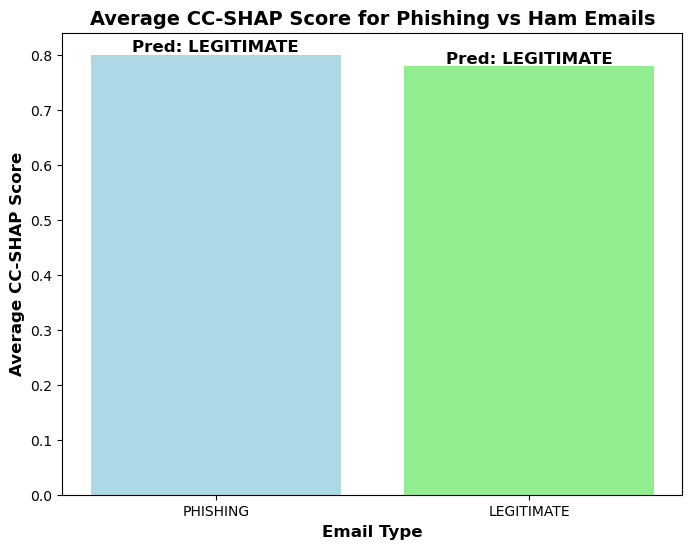

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama_8b_dpo123_classification_model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Tokenize text and move tensors to the model's device."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE and returns its probability."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the given prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

      
        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """
        Computes the CC‑SHAP score (cosine similarity between SHAP values of prediction and explanation),
        the predicted class, and the generated explanation.
        """
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = (
            f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        )
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_shap = pred_shap[:min_len]
        exp_shap = exp_shap[:min_len]

       
        pred_norm = pred_shap / (np.linalg.norm(pred_shap, ord=1) + 1e-10)
        exp_norm = exp_shap / (np.linalg.norm(exp_shap, ord=1) + 1e-10)

       
        if np.linalg.norm(pred_norm, ord=2) < 1e-6 or np.linalg.norm(exp_norm, ord=2) < 1e-6:
            similarity = 0.0 
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
   
    analyzer = Llama7BWithCCSHAP()

  
    df = pd.read_excel("Original_data.xlsx")

   
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

   
    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]



    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

   
    phishing_accuracy = np.mean([1 if pred == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred == "LEGITIMATE" else 0 for pred in ham_predictions])

   
    phishing_cc_shap_mean = np.mean(phishing_scores)
    phishing_cc_shap_std = np.std(phishing_scores)
    ham_cc_shap_mean = np.mean(ham_scores)
    ham_cc_shap_std = np.std(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")

    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading adapter weights from llama8b_binary_classification_model led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 1: CC‑SHAP = 0.800 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 2: CC‑SHAP = 0.935 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 3: CC‑SHAP = 0.711 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 4: CC‑SHAP = 0.871 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 5: CC‑SHAP = 0.942 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 6: CC‑SHAP = 0.955 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 7: CC‑SHAP = 0.866 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 8: CC‑SHAP = 0.863 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 9: CC‑SHAP = 0.886 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 10: CC‑SHAP = 0.515 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 11: CC‑SHAP = 0.812 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 12: CC‑SHAP = 0.876 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 13: CC‑SHAP = 0.616 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 14: CC‑SHAP = 0.445 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 15: CC‑SHAP = 0.876 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 16: CC‑SHAP = 0.894 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 17: CC‑SHAP = 0.627 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 18: CC‑SHAP = 0.836 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 19: CC‑SHAP = 0.918 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 20: CC‑SHAP = 0.912 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = 0.782 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.930 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.857 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.922 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.910 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.816 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.859 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.881 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.957 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.858 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.618 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.830 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.891 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.806 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.575 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.603 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.809 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.948 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.838 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.924 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 41: CC‑SHAP = 0.827 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 42: CC‑SHAP = 0.864 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 43: CC‑SHAP = 0.917 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 44: CC‑SHAP = 0.951 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 45: CC‑SHAP = 0.887 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 46: CC‑SHAP = 0.915 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 47: CC‑SHAP = 0.844 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 48: CC‑SHAP = 0.893 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 49: CC‑SHAP = 0.595 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 50: CC‑SHAP = 0.788 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 51: CC‑SHAP = 0.492 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 52: CC‑SHAP = 0.859 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 53: CC‑SHAP = 0.940 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 54: CC‑SHAP = 0.944 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 55: CC‑SHAP = 0.631 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 56: CC‑SHAP = 0.833 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 57: CC‑SHAP = 0.485 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 58: CC‑SHAP = 0.893 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 59: CC‑SHAP = 0.729 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 60: CC‑SHAP = 0.552 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 61: CC‑SHAP = 0.859 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 62: CC‑SHAP = 0.844 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 63: CC‑SHAP = 0.508 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 64: CC‑SHAP = 0.954 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 65: CC‑SHAP = 0.870 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 66: CC‑SHAP = 0.697 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 67: CC‑SHAP = 0.841 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 68: CC‑SHAP = 0.842 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 69: CC‑SHAP = 0.813 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 70: CC‑SHAP = 0.905 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 71: CC‑SHAP = 0.883 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 72: CC‑SHAP = 0.924 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 73: CC‑SHAP = 0.921 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 74: CC‑SHAP = 0.659 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 75: CC‑SHAP = 0.940 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 76: CC‑SHAP = 0.836 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 77: CC‑SHAP = 0.843 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 78: CC‑SHAP = 0.673 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 79: CC‑SHAP = 0.764 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 80: CC‑SHAP = 0.875 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 81: CC‑SHAP = 0.944 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 82: CC‑SHAP = 0.840 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 83: CC‑SHAP = 0.898 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 84: CC‑SHAP = 0.738 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 85: CC‑SHAP = 0.770 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 86: CC‑SHAP = 0.924 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 87: CC‑SHAP = 0.727 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 88: CC‑SHAP = 0.913 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 89: CC‑SHAP = 0.884 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 90: CC‑SHAP = 0.420 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 91: CC‑SHAP = 0.827 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 92: CC‑SHAP = 0.804 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 93: CC‑SHAP = 0.876 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 94: CC‑SHAP = 0.536 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 95: CC‑SHAP = 0.659 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 96: CC‑SHAP = 0.866 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 97: CC‑SHAP = 0.947 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 98: CC‑SHAP = 0.926 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 99: CC‑SHAP = 0.320 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 100: CC‑SHAP = 0.510 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 101: CC‑SHAP = 0.947 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 102: CC‑SHAP = 0.734 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 103: CC‑SHAP = 0.884 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 104: CC‑SHAP = 0.780 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 105: CC‑SHAP = 0.948 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 106: CC‑SHAP = 0.894 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 107: CC‑SHAP = 0.802 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 108: CC‑SHAP = 0.937 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 109: CC‑SHAP = 0.800 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 110: CC‑SHAP = 0.842 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 111: CC‑SHAP = 0.895 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 112: CC‑SHAP = 0.872 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 113: CC‑SHAP = 0.810 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 114: CC‑SHAP = 0.943 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 115: CC‑SHAP = 0.875 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 116: CC‑SHAP = 0.926 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 117: CC‑SHAP = 0.942 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 118: CC‑SHAP = 0.730 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 119: CC‑SHAP = 0.930 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 120: CC‑SHAP = 0.922 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 121: CC‑SHAP = 0.949 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 122: CC‑SHAP = 0.623 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 123: CC‑SHAP = 0.781 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 124: CC‑SHAP = 0.937 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 125: CC‑SHAP = 0.888 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 126: CC‑SHAP = 0.776 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 127: CC‑SHAP = 0.912 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 128: CC‑SHAP = 0.954 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 129: CC‑SHAP = 0.742 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 130: CC‑SHAP = 0.925 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 131: CC‑SHAP = 0.840 | Prediction: PHISHING
Processed PHISHING email 132: CC‑SHAP = 0.834 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 133: CC‑SHAP = 0.898 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 134: CC‑SHAP = 0.824 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 135: CC‑SHAP = 0.925 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 136: CC‑SHAP = 0.851 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 137: CC‑SHAP = 0.926 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 138: CC‑SHAP = 0.764 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 139: CC‑SHAP = 0.882 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 140: CC‑SHAP = 0.890 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 141: CC‑SHAP = 0.920 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 142: CC‑SHAP = 0.804 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 143: CC‑SHAP = 0.479 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 144: CC‑SHAP = 0.915 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 145: CC‑SHAP = 0.823 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 146: CC‑SHAP = 0.334 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 147: CC‑SHAP = 0.818 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 148: CC‑SHAP = 0.956 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 149: CC‑SHAP = 0.884 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 150: CC‑SHAP = 0.846 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 151: CC‑SHAP = 0.154 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 152: CC‑SHAP = 0.664 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 153: CC‑SHAP = 0.658 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 154: CC‑SHAP = 0.760 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 155: CC‑SHAP = 0.780 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 156: CC‑SHAP = 0.858 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 157: CC‑SHAP = 0.382 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 158: CC‑SHAP = 0.869 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 159: CC‑SHAP = 0.853 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 160: CC‑SHAP = 0.676 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 161: CC‑SHAP = 0.700 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 162: CC‑SHAP = 0.907 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 163: CC‑SHAP = 0.876 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 164: CC‑SHAP = 0.645 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 165: CC‑SHAP = 0.573 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 166: CC‑SHAP = 0.840 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 167: CC‑SHAP = 0.714 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 168: CC‑SHAP = 0.882 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 169: CC‑SHAP = 0.916 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 170: CC‑SHAP = 0.863 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 171: CC‑SHAP = 0.712 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 172: CC‑SHAP = 0.782 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 173: CC‑SHAP = 0.654 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 174: CC‑SHAP = 0.562 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 175: CC‑SHAP = 0.715 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 176: CC‑SHAP = 0.140 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 177: CC‑SHAP = 0.918 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 178: CC‑SHAP = 0.504 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 179: CC‑SHAP = 0.806 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 180: CC‑SHAP = 0.902 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 181: CC‑SHAP = 0.916 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 182: CC‑SHAP = 0.714 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 183: CC‑SHAP = 0.740 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 184: CC‑SHAP = 0.797 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 185: CC‑SHAP = 0.693 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed PHISHING email 186: CC‑SHAP = 0.944 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 187: CC‑SHAP = 0.880 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 188: CC‑SHAP = 0.876 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 189: CC‑SHAP = 0.819 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 190: CC‑SHAP = 0.795 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 191: CC‑SHAP = 0.487 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 192: CC‑SHAP = 0.730 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 193: CC‑SHAP = 0.706 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 194: CC‑SHAP = 0.869 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 195: CC‑SHAP = 0.856 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 196: CC‑SHAP = 0.954 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 197: CC‑SHAP = 0.872 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 198: CC‑SHAP = 0.663 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 199: CC‑SHAP = 0.878 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Processed HAM email 200: CC‑SHAP = 0.648 | Prediction: LEGITIMATE


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 201: CC‑SHAP = 0.893 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 202: CC‑SHAP = 0.569 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 203: CC‑SHAP = 0.894 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 204: CC‑SHAP = 0.790 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 205: CC‑SHAP = 0.829 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 206: CC‑SHAP = 0.548 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 207: CC‑SHAP = 0.836 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 208: CC‑SHAP = 0.399 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 209: CC‑SHAP = 0.765 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 210: CC‑SHAP = 0.895 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 211: CC‑SHAP = 0.804 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 212: CC‑SHAP = 0.832 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 213: CC‑SHAP = 0.926 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 214: CC‑SHAP = 0.785 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 215: CC‑SHAP = 0.926 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 216: CC‑SHAP = 0.910 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 217: CC‑SHAP = 0.949 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 218: CC‑SHAP = 0.774 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 219: CC‑SHAP = 0.620 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 220: CC‑SHAP = 0.884 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 221: CC‑SHAP = 0.807 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 222: CC‑SHAP = 0.879 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 223: CC‑SHAP = 0.788 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 224: CC‑SHAP = 0.872 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 225: CC‑SHAP = 0.816 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 226: CC‑SHAP = 0.901 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 227: CC‑SHAP = 0.936 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 228: CC‑SHAP = 0.692 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 229: CC‑SHAP = 0.768 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 230: CC‑SHAP = 0.714 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 231: CC‑SHAP = 0.767 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 232: CC‑SHAP = 0.733 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 233: CC‑SHAP = 0.862 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 234: CC‑SHAP = 0.785 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 235: CC‑SHAP = 0.876 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 236: CC‑SHAP = 0.856 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 237: CC‑SHAP = 0.770 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 238: CC‑SHAP = 0.832 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 239: CC‑SHAP = 0.684 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 240: CC‑SHAP = 0.861 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Processed HAM email 241: CC‑SHAP = 0.867 | Prediction: PHISHING

Phishing Accuracy: 25.81%
Ham Accuracy: 81.82%

Phishing CC‑SHAP Mean: 0.800 | Std: 0.152
Ham CC‑SHAP Mean: 0.799 | Std: 0.115


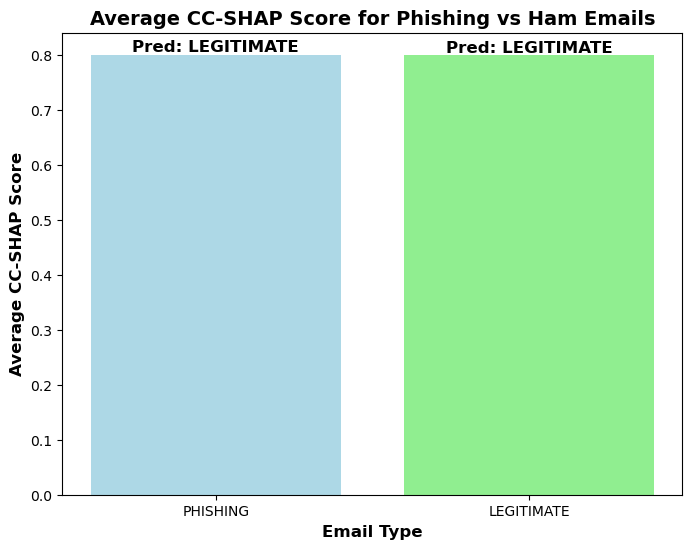

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple, List, Dict, Any
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForSequenceClassification
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama8b_binary_classification_model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:0" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation

if __name__ == "__main__":
    analyzer = Llama7BWithCCSHAP()

    # Load data from Excel
    df = pd.read_excel("Original_data.xlsx")
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    # Calculate accuracies using nan-safe aggregations
    phishing_accuracy = np.mean([1 if pred.upper() == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred.upper() == "LEGITIMATE" else 0 for pred in ham_predictions])

    phishing_cc_shap_mean = np.nanmean(phishing_scores)
    phishing_cc_shap_std = np.nanstd(phishing_scores)
    ham_cc_shap_mean = np.nanmean(ham_scores)
    ham_cc_shap_std = np.nanstd(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")
    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x
() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading adapter weights from wizard8b_binary_classification_model led to unexpected keys not found in the model: score.weight. 
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Model loaded on cuda:1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 1: CC‑SHAP = 0.006 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 2: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 3: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 4: CC‑SHAP = 0.604 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 5: CC‑SHAP = 0.101 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 6: CC‑SHAP = 0.127 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 7: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 8: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 9: CC‑SHAP = 0.392 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 10: CC‑SHAP = 0.265 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 11: CC‑SHAP = 0.285 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 12: CC‑SHAP = 0.072 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 13: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 14: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 15: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 16: CC‑SHAP = 0.035 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 17: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 18: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 19: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 20: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 21: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 22: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 23: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 24: CC‑SHAP = 0.082 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 25: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 26: CC‑SHAP = 0.028 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 27: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 28: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 29: CC‑SHAP = 0.012 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 30: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 31: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 32: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 33: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 34: CC‑SHAP = 0.066 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 35: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 36: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 37: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 38: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 39: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 40: CC‑SHAP = 0.117 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 41: CC‑SHAP = 0.090 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 42: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 43: CC‑SHAP = 0.034 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 44: CC‑SHAP = 0.010 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 45: CC‑SHAP = 0.009 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 46: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 47: CC‑SHAP = 0.011 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 48: CC‑SHAP = 0.152 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 49: CC‑SHAP = 0.083 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 50: CC‑SHAP = 0.235 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 51: CC‑SHAP = 0.115 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 52: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 53: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 54: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 55: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 56: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 57: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 58: CC‑SHAP = 0.138 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 59: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 60: CC‑SHAP = 0.082 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 61: CC‑SHAP = 0.145 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 62: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 63: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 64: CC‑SHAP = 0.028 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 65: CC‑SHAP = 0.018 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 66: CC‑SHAP = 0.094 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 67: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 68: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 69: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 70: CC‑SHAP = 0.039 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 71: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 72: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 73: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 74: CC‑SHAP = 0.101 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 75: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 76: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 77: CC‑SHAP = 0.064 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 78: CC‑SHAP = 0.081 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 79: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 80: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 81: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 82: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 83: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 84: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 85: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 86: CC‑SHAP = 0.008 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 87: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 88: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 89: CC‑SHAP = 0.062 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 90: CC‑SHAP = 0.435 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 91: CC‑SHAP = 0.013 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 92: CC‑SHAP = 0.016 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 93: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 94: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 95: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 96: CC‑SHAP = 0.093 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 97: CC‑SHAP = 0.041 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 98: CC‑SHAP = 0.228 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 99: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 100: CC‑SHAP = 0.256 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 101: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 102: CC‑SHAP = 0.030 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 103: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 104: CC‑SHAP = 0.181 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 105: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 106: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 107: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 108: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 109: CC‑SHAP = 0.006 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 110: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 111: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 112: CC‑SHAP = 0.054 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 113: CC‑SHAP = 0.122 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 114: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 115: CC‑SHAP = 0.039 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 116: CC‑SHAP = 0.125 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 117: CC‑SHAP = 0.224 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 118: CC‑SHAP = 0.077 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 119: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 120: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 121: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 122: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 123: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 124: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 125: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 126: CC‑SHAP = 0.022 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 127: CC‑SHAP = 0.098 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 128: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 129: CC‑SHAP = 0.024 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 130: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 131: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 132: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 133: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 134: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 135: CC‑SHAP = 0.010 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 136: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 137: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 138: CC‑SHAP = 0.019 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 139: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 140: CC‑SHAP = 0.119 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 141: CC‑SHAP = 0.243 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 142: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 143: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 144: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 145: CC‑SHAP = 0.036 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 146: CC‑SHAP = 0.160 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 147: CC‑SHAP = 0.412 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 148: CC‑SHAP = 0.342 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 149: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 150: CC‑SHAP = 0.108 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 151: CC‑SHAP = 0.106 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 152: CC‑SHAP = 0.079 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 153: CC‑SHAP = 0.051 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 154: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 155: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 156: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 157: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 158: CC‑SHAP = 0.036 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 159: CC‑SHAP = 0.017 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 160: CC‑SHAP = 0.065 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 161: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 162: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 163: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 164: CC‑SHAP = 0.306 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 165: CC‑SHAP = 0.119 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 166: CC‑SHAP = 0.303 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 167: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 168: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 169: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 170: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 171: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 172: CC‑SHAP = 0.006 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 173: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 174: CC‑SHAP = 0.248 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 175: CC‑SHAP = 0.029 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 176: CC‑SHAP = 0.002 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 177: CC‑SHAP = 0.077 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 178: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 179: CC‑SHAP = 0.235 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 180: CC‑SHAP = 0.039 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 181: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 182: CC‑SHAP = 0.239 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 183: CC‑SHAP = 0.130 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 184: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 185: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed PHISHING email 186: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 187: CC‑SHAP = 0.163 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 188: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 189: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 190: CC‑SHAP = 0.204 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 191: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 192: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 193: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 194: CC‑SHAP = 0.064 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 195: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 196: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 197: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 198: CC‑SHAP = 0.124 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 199: CC‑SHAP = 0.250 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 200: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 201: CC‑SHAP = 0.281 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 202: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 203: CC‑SHAP = 0.150 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 204: CC‑SHAP = 0.189 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 205: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 206: CC‑SHAP = 0.196 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 207: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 208: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 209: CC‑SHAP = 0.189 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 210: CC‑SHAP = 0.273 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 211: CC‑SHAP = 0.371 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 212: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 213: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 214: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 215: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 216: CC‑SHAP = 0.091 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 217: CC‑SHAP = 0.069 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 218: CC‑SHAP = 0.222 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 219: CC‑SHAP = 0.105 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 220: CC‑SHAP = 0.130 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 221: CC‑SHAP = 0.114 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 222: CC‑SHAP = 0.077 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 223: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 224: CC‑SHAP = 0.114 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 225: CC‑SHAP = 0.019 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 226: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 227: CC‑SHAP = 0.003 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 228: CC‑SHAP = 0.001 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 229: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 230: CC‑SHAP = 0.000 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 231: CC‑SHAP = 0.002 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 232: CC‑SHAP = 0.257 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 233: CC‑SHAP = 0.019 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 234: CC‑SHAP = 0.002 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 235: CC‑SHAP = 0.089 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 236: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 237: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 238: CC‑SHAP = 0.264 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 239: CC‑SHAP = 0.109 | Prediction: LEGITIMATE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 240: CC‑SHAP = 0.000 | Prediction: PHISHING


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Processed HAM email 241: CC‑SHAP = 0.090 | Prediction: PHISHING

Phishing Accuracy: 69.35%
Ham Accuracy: 74.55%

Phishing CC‑SHAP Mean: 0.051 | Std: 0.096
Ham CC‑SHAP Mean: 0.077 | Std: 0.099


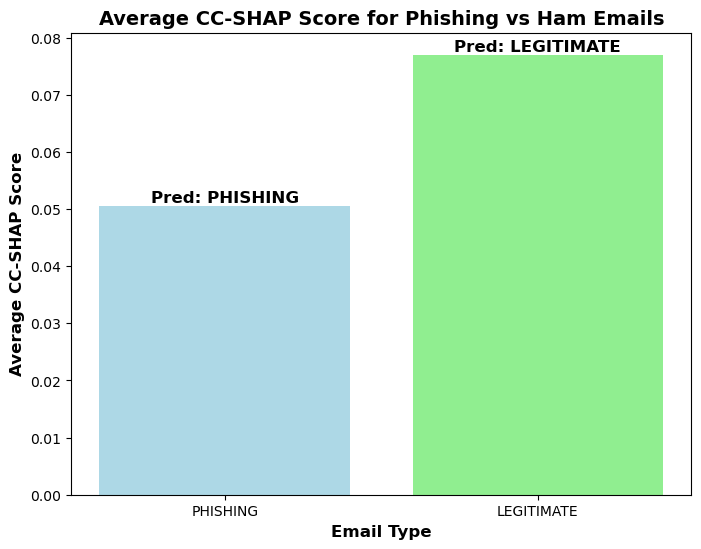

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple, List, Dict, Any
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForSequenceClassification
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "wizard8b_binary_classification_model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:1" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        if np.linalg.norm(pred_norm, ord=1) < 1e-6 or np.linalg.norm(exp_norm, ord=1) < 1e-6:
            similarity = 0.0 
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation
       

if __name__ == "__main__":
    analyzer = Llama7BWithCCSHAP()

    # Load data from Excel
    df = pd.read_excel("Original_data.xlsx")
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    # Calculate accuracies using nan-safe aggregations
    phishing_accuracy = np.mean([1 if pred.upper() == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred.upper() == "LEGITIMATE" else 0 for pred in ham_predictions])

    phishing_cc_shap_mean = np.nanmean(phishing_scores)
    phishing_cc_shap_std = np.nanstd(phishing_scores)
    ham_cc_shap_mean = np.nanmean(ham_scores)
    ham_cc_shap_std = np.nanstd(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")
    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x
() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter weights from llama_7B_contrastive_classification_model_lora_chat led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:1
Processed PHISHING email 1: CC‑SHAP = 0.864 | Prediction: PHISHING
Processed PHISHING email 2: CC‑SHAP = 0.879 | Prediction: PHISHING
Processed PHISHING email 3: CC‑SHAP = 0.963 | Prediction: LEGITIMATE
Processed PHISHING email 4: CC‑SHAP = 0.964 | Prediction: LEGITIMATE
Processed PHISHING email 5: CC‑SHAP = 0.924 | Prediction: PHISHING
Processed PHISHING email 6: CC‑SHAP = 0.898 | Prediction: PHISHING
Processed PHISHING email 7: CC‑SHAP = 0.889 | Prediction: PHISHING
Processed PHISHING email 8: CC‑SHAP = 0.888 | Prediction: PHISHING
Processed PHISHING email 9: CC‑SHAP = 0.964 | Prediction: LEGITIMATE
Processed PHISHING email 10: CC‑SHAP = 0.966 | Prediction: LEGITIMATE
Processed PHISHING email 11: CC‑SHAP = 0.970 | Prediction: LEGITIMATE
Processed PHISHING email 12: CC‑SHAP = 0.958 | Prediction: LEGITIMATE
Processed PHISHING email 13: CC‑SHAP = 0.799 | Prediction: PHISHING
Processed PHISHING email 14: CC‑SHAP = 0.825 | Prediction: PHISHING
Processed PHISHING ema

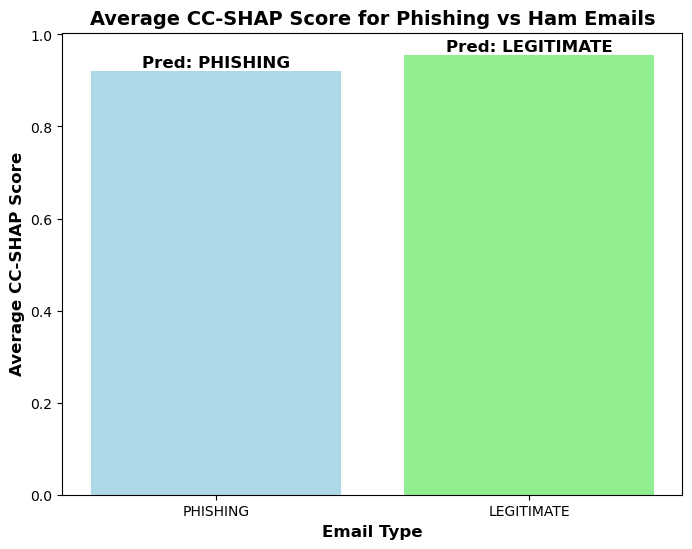

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple, List, Dict, Any
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForSequenceClassification
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama_7B_contrastive_classification_model_lora_chat"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:1" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        if np.linalg.norm(pred_norm, ord=1) < 1e-6 or np.linalg.norm(exp_norm, ord=1) < 1e-6:
            similarity = 0.0 
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation
       

if __name__ == "__main__":
    analyzer = Llama7BWithCCSHAP()

    # Load data from Excel
    df = pd.read_excel("Original_data.xlsx")
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    # Calculate accuracies using nan-safe aggregations
    phishing_accuracy = np.mean([1 if pred.upper() == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred.upper() == "LEGITIMATE" else 0 for pred in ham_predictions])

    phishing_cc_shap_mean = np.nanmean(phishing_scores)
    phishing_cc_shap_std = np.nanstd(phishing_scores)
    ham_cc_shap_mean = np.nanmean(ham_scores)
    ham_cc_shap_std = np.nanstd(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")
    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x
() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter weights from llama_7b_dpo_classification_model_chat led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:1
Processed PHISHING email 1: CC‑SHAP = 0.800 | Prediction: PHISHING
Processed PHISHING email 2: CC‑SHAP = 0.877 | Prediction: PHISHING
Processed PHISHING email 3: CC‑SHAP = 0.918 | Prediction: PHISHING
Processed PHISHING email 4: CC‑SHAP = 0.966 | Prediction: LEGITIMATE
Processed PHISHING email 5: CC‑SHAP = 0.876 | Prediction: PHISHING
Processed PHISHING email 6: CC‑SHAP = 0.812 | Prediction: PHISHING
Processed PHISHING email 7: CC‑SHAP = 0.929 | Prediction: PHISHING
Processed PHISHING email 8: CC‑SHAP = 0.891 | Prediction: PHISHING
Processed PHISHING email 9: CC‑SHAP = 0.973 | Prediction: LEGITIMATE
Processed PHISHING email 10: CC‑SHAP = 0.867 | Prediction: PHISHING
Processed PHISHING email 11: CC‑SHAP = 0.965 | Prediction: LEGITIMATE
Processed PHISHING email 12: CC‑SHAP = 0.960 | Prediction: LEGITIMATE
Processed PHISHING email 13: CC‑SHAP = 0.889 | Prediction: PHISHING
Processed PHISHING email 14: CC‑SHAP = 0.896 | Prediction: PHISHING
Processed PHISHING email 1

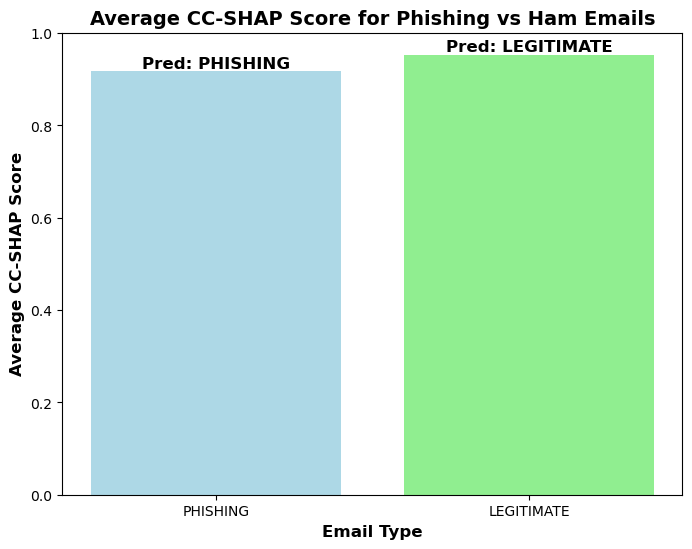

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple, List, Dict, Any
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForSequenceClassification
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "llama_7b_dpo_classification_model_chat"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:1" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        if np.linalg.norm(pred_norm, ord=1) < 1e-6 or np.linalg.norm(exp_norm, ord=1) < 1e-6:
            similarity = 0.0 
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation
       

if __name__ == "__main__":
    analyzer = Llama7BWithCCSHAP()

    # Load data from Excel
    df = pd.read_excel("Original_data.xlsx")
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    # Calculate accuracies using nan-safe aggregations
    phishing_accuracy = np.mean([1 if pred.upper() == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred.upper() == "LEGITIMATE" else 0 for pred in ham_predictions])

    phishing_cc_shap_mean = np.nanmean(phishing_scores)
    phishing_cc_shap_std = np.nanstd(phishing_scores)
    ham_cc_shap_mean = np.nanmean(ham_scores)
    ham_cc_shap_std = np.nanstd(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")
    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x
() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/skuikel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter weights from lama7b_binary_classification_model_chat led to unexpected keys not found in the model: score.weight. 


Model loaded on cuda:1
Processed PHISHING email 1: CC‑SHAP = 0.820 | Prediction: PHISHING
Processed PHISHING email 2: CC‑SHAP = 0.863 | Prediction: PHISHING
Processed PHISHING email 3: CC‑SHAP = 0.969 | Prediction: LEGITIMATE
Processed PHISHING email 4: CC‑SHAP = 0.966 | Prediction: LEGITIMATE
Processed PHISHING email 5: CC‑SHAP = 0.892 | Prediction: PHISHING
Processed PHISHING email 6: CC‑SHAP = 0.872 | Prediction: PHISHING
Processed PHISHING email 7: CC‑SHAP = 0.903 | Prediction: PHISHING
Processed PHISHING email 8: CC‑SHAP = 0.888 | Prediction: PHISHING
Processed PHISHING email 9: CC‑SHAP = 0.971 | Prediction: LEGITIMATE
Processed PHISHING email 10: CC‑SHAP = 0.918 | Prediction: PHISHING
Processed PHISHING email 11: CC‑SHAP = 0.965 | Prediction: LEGITIMATE
Processed PHISHING email 12: CC‑SHAP = 0.969 | Prediction: LEGITIMATE
Processed PHISHING email 13: CC‑SHAP = 0.831 | Prediction: PHISHING
Processed PHISHING email 14: CC‑SHAP = 0.862 | Prediction: PHISHING
Processed PHISHING email

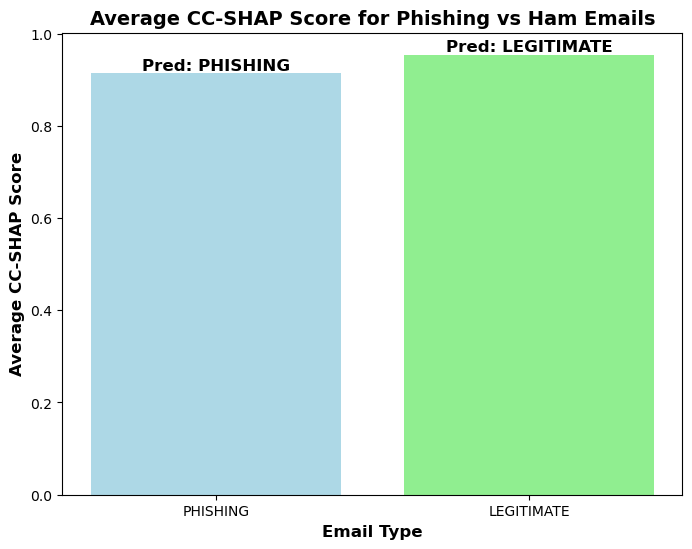

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import Tuple, List, Dict, Any
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import string
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForSequenceClassification
from typing import Tuple
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stop words
nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))

class Llama7BWithCCSHAP:
    def __init__(self, model_name: str = "lama7b_binary_classification_model_chat"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token 
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="cuda:1" 
        )
        self.model.eval()
        self.classes = ["PHISHING", "LEGITIMATE"]
        print(f"Model loaded on {next(self.model.parameters()).device}")

    def preprocess_text(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        """Ensures input tensors are on the same device as the model."""
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=1024
        )
        model_device = next(self.model.parameters()).device
        return inputs["input_ids"].to(model_device), inputs["attention_mask"].to(model_device)

    def get_prediction_and_logits(self, prompt: str) -> Tuple[str, float]:
        """Predicts whether the email is PHISHING or LEGITIMATE."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

        # Simple rule: if the generated output contains "PHISHING", label it as such.
        decoded = self.tokenizer.decode(
            self.model.generate(
                input_ids=input_ids,
                max_new_tokens=60,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )[0],
            skip_special_tokens=True
        )
        prediction = "PHISHING" if "PHISHING" in decoded.upper() else "LEGITIMATE"
       
        class_idx = 0 if prediction.upper() == "PHISHING" else 1
        pred_prob = probs[0, class_idx].item()
        return prediction, pred_prob

    def get_explanation(self, text: str, predicted_class: str) -> str:
        """Generates an explanation for the prediction."""
        prompt = (
            f"Provide a detailed reasoning for classifying this email as {predicted_class}. "
            "List key indicators for the classification.\n\n"
            f"Email:\n{text}\n\nExplanation:"
        )
        input_ids, attention_mask = self.preprocess_text(prompt)
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=input_ids,
                max_new_tokens=350,
                do_sample=True,
                temperature=0.7,
                top_p=0.9
            )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def compute_shap_values(self, prompt: str, target_class: str) -> np.ndarray:
        """Computes SHAP values using structured coalition sampling."""
        input_ids, attention_mask = self.preprocess_text(prompt)
        n_tokens = input_ids.shape[1]
        shap_values = np.zeros(n_tokens)

        # Use structured Monte Carlo sampling
        n_samples = min(2 ** n_tokens + 12, 100)

        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, -1, :]
            class_idx = 0 if "PHISHING" in target_class.upper() else 1
            baseline_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

        for _ in range(n_samples):
            coalition_size = np.random.randint(1, n_tokens + 1)
            mask_indices = np.random.choice(n_tokens, size=coalition_size, replace=False)

            mask = torch.zeros_like(input_ids, dtype=torch.bool)
            mask[:, mask_indices] = True  

            masked_input = torch.where(
                mask, input_ids, torch.full_like(input_ids, self.tokenizer.pad_token_id, dtype=torch.long)
            )
            masked_attention = torch.where(mask, attention_mask, torch.zeros_like(attention_mask))

            with torch.no_grad():
                outputs = self.model(masked_input, attention_mask=masked_attention)
                logits = outputs.logits[:, -1, :]
                coalition_prob = torch.softmax(logits, dim=-1)[0, class_idx].item()

            marginal = coalition_prob - baseline_prob
            shap_values[mask_indices] += marginal / n_samples

        shap_values /= (np.linalg.norm(shap_values, ord=1) + 1e-10)
        return shap_values

    def compute_cc_shap(self, text: str) -> Tuple[float, str, str]:
        """Computes the CC‑SHAP score (cosine similarity), prediction, and explanation."""
        prediction_prompt = f"Classify this email type:\n\n{text}\n\nClassification:"
        prediction, _ = self.get_prediction_and_logits(prediction_prompt)

        explanation = self.get_explanation(text, prediction)

        pred_shap = self.compute_shap_values(prediction_prompt, prediction)
        explanation_prompt = f"Provide a detailed reasoning for classifying this email as {prediction}:\n\n{text}\n\nExplanation:"
        exp_shap = self.compute_shap_values(explanation_prompt, prediction)

       
        min_len = min(len(pred_shap), len(exp_shap))
        pred_norm = pred_shap[:min_len] / (np.linalg.norm(pred_shap[:min_len], ord=1) + 1e-10)
        exp_norm = exp_shap[:min_len] / (np.linalg.norm(exp_shap[:min_len], ord=1) + 1e-10)
        if np.linalg.norm(pred_norm, ord=1) < 1e-6 or np.linalg.norm(exp_norm, ord=1) < 1e-6:
            similarity = 0.0 
        else:
            similarity = 1 - cosine(pred_norm, exp_norm)

        return similarity, prediction, explanation
       

if __name__ == "__main__":
    analyzer = Llama7BWithCCSHAP()

    # Load data from Excel
    df = pd.read_excel("Original_data.xlsx")
    df["email_text"] = (
        df["Subject"].fillna('') + "\nFrom: " + 
        df["Sender"].fillna('') + "\n\n" + 
        df["Email"].fillna('')
    )

    phishing_emails = df[df["Email_type"] == "Phishing"]
    ham_emails = df[df["Email_type"].str.lower() == "ham"]

    phishing_scores = []
    phishing_predictions = []
    for idx, row in phishing_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        phishing_scores.append(cc_shap_score)
        phishing_predictions.append(prediction)
        print(f"Processed PHISHING email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    ham_scores = []
    ham_predictions = []
    for idx, row in ham_emails.iterrows():
        email_text = row["email_text"]
        cc_shap_score, prediction, explanation = analyzer.compute_cc_shap(email_text)
        ham_scores.append(cc_shap_score)
        ham_predictions.append(prediction)
        print(f"Processed HAM email {idx+1}: CC‑SHAP = {cc_shap_score:.3f} | Prediction: {prediction}")

    # Calculate accuracies using nan-safe aggregations
    phishing_accuracy = np.mean([1 if pred.upper() == "PHISHING" else 0 for pred in phishing_predictions])
    ham_accuracy = np.mean([1 if pred.upper() == "LEGITIMATE" else 0 for pred in ham_predictions])

    phishing_cc_shap_mean = np.nanmean(phishing_scores)
    phishing_cc_shap_std = np.nanstd(phishing_scores)
    ham_cc_shap_mean = np.nanmean(ham_scores)
    ham_cc_shap_std = np.nanstd(ham_scores)

    print(f"\nPhishing Accuracy: {phishing_accuracy*100:.2f}%")
    print(f"Ham Accuracy: {ham_accuracy*100:.2f}%\n")

    print(f"Phishing CC‑SHAP Mean: {phishing_cc_shap_mean:.3f} | Std: {phishing_cc_shap_std:.3f}")
    print(f"Ham CC‑SHAP Mean: {ham_cc_shap_mean:.3f} | Std: {ham_cc_shap_std:.3f}")
    
    phishing_majority = Counter(phishing_predictions).most_common(1)[0][0]
    ham_majority = Counter(ham_predictions).most_common(1)[0][0]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(["PHISHING", "LEGITIMATE"], [phishing_cc_shap_mean, ham_cc_shap_mean],
                   color=["lightblue", "lightgreen"])
    plt.xlabel("Email Type", fontsize=12, weight='bold')
    plt.ylabel("Average CC‑SHAP Score", fontsize=12, weight='bold')
    plt.title("Average CC‑SHAP Score for Phishing vs Ham Emails", fontsize=14, weight='bold')

    for bar, pred in zip(bars, [phishing_majority, ham_majority]):
        plt.text(
            bar.get_x
() + bar.get_width()/2,
            bar.get_height(),
            f"Pred: {pred}",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight='bold'
        )
    plt.show()
